In [1]:
import hssm 
hssm.set_floatX("float32")

# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

# from jax.config import config

import numpyro

numpyro.set_host_device_count(4)


import warnings
warnings.filterwarnings('ignore')

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [2]:
base_dir = '/sc/arion'
save_dir_plots = f'{base_dir}/projects/guLab/Salman/MemoryBanditManuscript/Figures/Exp1'

In [3]:
# Compute the factor scores for everyone:
factor_scores = pd.read_csv('/sc/arion/work/qasims01/MemoryBanditData/Prolific/revised_factor_scores_R.csv')
f1_score = factor_scores.values[:, 0]
f2_score = factor_scores.values[:, 1]
f3_score = factor_scores.values[:, 2]

In [4]:
df = pd.read_csv('/sc/arion/projects/guLab/Salman/Prolific/blair_data.csv')

# # Preprocess the data into the right format for HSSM 
# df.rename(columns={'recog_rt': 'rt',
#                         'recog_choice_bool': 'response',
#                         'participant': 'subj_idx',
#                         'image_dprime': 'pm'
#                         }, inplace=True)


# # Stick to the stuff I need 
# df = df[['subj_idx', 'rt', 'response', 'pm', 'rpe']]

# # Stick to RPE trials
# df.dropna(inplace=True)

# # compute means and sds by subject
# means = df.groupby('subj_idx').rt.apply(lambda x: np.nanmean(x)).reset_index()
# twosd = df.groupby('subj_idx').rt.apply(lambda x: np.nanstd(x)*2).reset_index()

# df['zrpe'] = np.nan
# df['zpm'] = np.nan
# df['log_pm'] = np.nan
# df['log_rpe'] = np.nan

# for subj in df.subj_idx.unique(): 
#     df['log_rpe'][df.subj_idx==subj] = np.log(np.abs(df['rpe'][df.subj_idx==subj]))
#     df['log_pm'][df.subj_idx==subj] = np.log(df['pm'][df.subj_idx==subj])

#     df['zrpe'][df.subj_idx==subj] = sp.stats.zscore(df['rpe'][df.subj_idx==subj])
#     df['zpm'][df.subj_idx==subj] = sp.stats.zscore(df['pm'][df.subj_idx==subj])
#     # apply 2 SD threshold
#     df['rt'][df.subj_idx==subj] = df['rt'][df.subj_idx==subj].apply(lambda x: x if ((x < means[means['subj_idx']==subj].rt.values[0] + twosd[twosd['subj_idx']==subj].rt.values[0]) & (x > means[means['subj_idx']==subj].rt.values[0] - twosd[twosd['subj_idx']==subj].rt.values[0])) else np.nan)
    

# # clean out trash 
# df.dropna(inplace=True)

# # and set a hard threshold
# df = df[(df.rt > 0.4) & (df.rt < 10)]

# df.loc[df.response==0, 'response'] = -1

In [11]:
df.trials_gamble

0         NaN
1        27.0
2         NaN
3         NaN
4         NaN
         ... 
20755    12.0
20756     NaN
20757    21.0
20758     NaN
20759     3.0
Name: trials_gamble, Length: 20760, dtype: float64

In [12]:
df.block.unique()

array([nan,  3.,  2.,  5.,  4.,  1.])

In [16]:
sum(df.prob.dropna() - df.reward.dropna())

0.0

In [7]:
list(df.keys())

['img_path',
 'participant',
 'recog_choice',
 'recog_rt',
 'conf_choice',
 'conf_rt',
 'trials_mem',
 'recog_choice_bool',
 'hits',
 'misses',
 'false_alarms',
 'correct_rejections',
 'hit_rate',
 'false_alarm_rate',
 'dprime',
 'crit',
 'mcc',
 'acc',
 'image_dprime',
 'gamble',
 'gamble_rt',
 'prob',
 'block',
 'gamble_label',
 'reward',
 'trials_gamble',
 'good_dm_performance',
 'male',
 'female',
 'alpha',
 'beta',
 'rpe',
 'gamble_rt_log',
 '_merge',
 'conf_rt_log',
 'recog_rt_log',
 'age',
 'Sex',
 'record_id',
 'redcap_survey_identifier',
 'id_grab_timestamp',
 'record_id_e587ae',
 'study_id',
 'session_id',
 'correct_id',
 'prolific_pid_corrected',
 'id_grab_complete',
 'stai_s_timestamp',
 'stais1',
 'stais2',
 'stais3',
 'stais4',
 'stais5',
 'stais6',
 'stais7',
 'stais8',
 'stais9',
 'stais10',
 'stais11',
 'stais12',
 'stais13',
 'stais14',
 'stais15',
 'stais16',
 'stais17',
 'stais18',
 'stais19',
 'stais20',
 'stai_s_score',
 'stai_s_complete',
 'stai_t_timestamp',
 's

In [5]:
df['log_rt'] = np.log(df['rt'])

In [6]:
df[['subj_idx', 'rt', 'response', 'log_pm']]

subj_idx      rt  response    log_pm
1      5f80c3b14dc3ba1509305a89  1.7147        -1  0.681025
8      5f80c3b14dc3ba1509305a89  2.0131        -1  0.537520
10     5f80c3b14dc3ba1509305a89  2.5377        -1  0.820643
11     5f80c3b14dc3ba1509305a89  1.6474         1  1.016147
13     5f80c3b14dc3ba1509305a89  1.7971        -1  0.640257
...                         ...     ...       ...       ...
20749  5cc22481f6ef910019e5120f  1.0475        -1  0.803132
20750  5cc22481f6ef910019e5120f  0.7231         1  0.777650
20751  5cc22481f6ef910019e5120f  1.0923        -1  0.629124
20755  5cc22481f6ef910019e5120f  1.4180        -1  0.812596
20759  5cc22481f6ef910019e5120f  1.0998        -1  1.019138

[9831 rows x 4 columns]

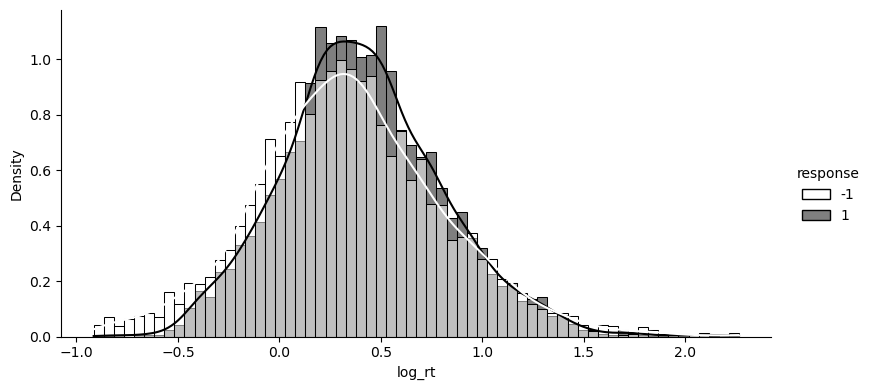

In [114]:
with PdfPages(f'{save_dir_plots}/Exp1_RTs_for_DDM.pdf') as pdf:    

    g = sns.displot(df, x="log_rt", hue="response", kde=True, common_norm=False,
                    stat="density", height=4, aspect=2, palette='Greys',
                    hue_norm=(-1, 1))  # Use hue_norm to ensure proper inversion

    pdf.savefig()

In [39]:
# sub-sample my data for 10 participants

sampled_df = df.groupby('subj_idx').apply(lambda group: group.sample(n=10, random_state=42)).reset_index(drop=True)

# Resetting index to get a clean DataFrame
sampled_df.reset_index(drop=True, inplace=True)

# make my models 
pooled_analytical = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=sampled_df[['rt', 'response']] ,
    loglik_kind='analytical'
)

pooled_approx = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=sampled_df[['rt', 'response']] ,
    loglik_kind='approx_differentiable'
)

# include=[
#     {
#         "name": "t",  
#         "prior": {
#                 "name": "Uniform",
#                 "lower": 0.0,
#                 "upper": 2.0,
#                 "initval": 0.1,
#         },
#     }
# ],

In [40]:


model_types = {'pooled_analytical':pooled_analytical,
               'pooled_approx':pooled_approx}

# fit the models and compare 
if __name__ == "__main__":
    model_res = {f'{x}':[] for x in model_types.keys()}

    # output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

    for model_key, model in model_types.items(): 
        idata = model.sample(
            sampler='nuts_numpyro',
            chains = 4,
            cores = 4,
            draws = 1000,
            tune = 1000,
            idata_kwargs=dict(log_likelihood=True))

        # az.to_netcdf(idata, f"{output_dir}/{model_key}_model")

        model_res[model_key] = idata

    df_comp_loo = az.compare(model_res, ic='loo')
    


Compiling...
Compilation time = 0:00:03.077190
Sampling...
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/elemwise.py:43: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/scalar.py:174: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x).astype(op.o_type.dtype)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:39.957723
Transforming variables...
Transformation time = 0:00:00.129837
Computing Log Likelihood...
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/elemwise.py:43: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
Log Likelihood time = 0:00:02.351830
Compiling...
Compilation time = 0:00:01.511166
Sampling...
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/scalar.py:174: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment v

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:46.141330
Transforming variables...
Transformation time = 0:00:00.179611
Computing Log Likelihood...
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/scalar.py:174: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x).astype(op.o_type.dtype)
Log Likelihood time = 0:00:06.316909
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

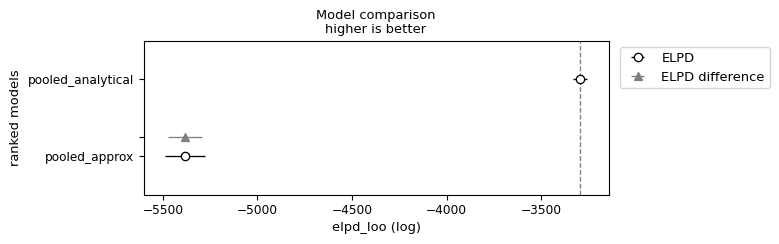

In [41]:
az.plot_compare(df_comp_loo)

In [42]:
# Simulate some data
from ssms.basic_simulators import simulator

# Specify parameters
# v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.2]


# Simulate data
sim_out = simulator(
    theta=[model_res['pooled_approx']['posterior']['v'].mean().values, 
           model_res['pooled_approx']['posterior']['a'].mean().values, 
           model_res['pooled_approx']['posterior']['z'].mean().values, 
           model_res['pooled_approx']['posterior']['t'].mean().values],  # parameter list
    model="ddm",  # specify model (many are included in ssms)
    n_samples=500,  # number of samples for each set of parameters
)

# Turn into nice dataset
# Turn data into a pandas dataframe
dataset = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)


In [47]:
np.nanmin(dataset.rt)

0.7046888470649719

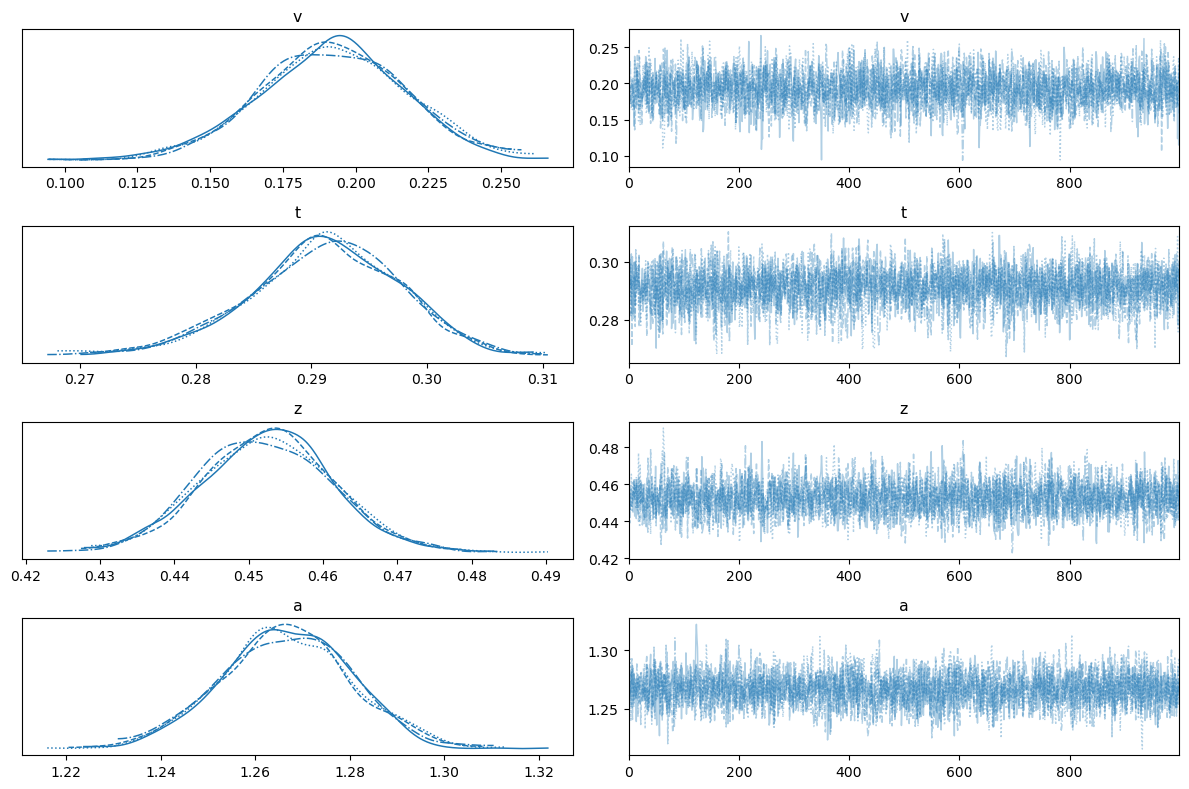

In [44]:
az.plot_trace(model_res['pooled_analytical'])
plt.tight_layout()

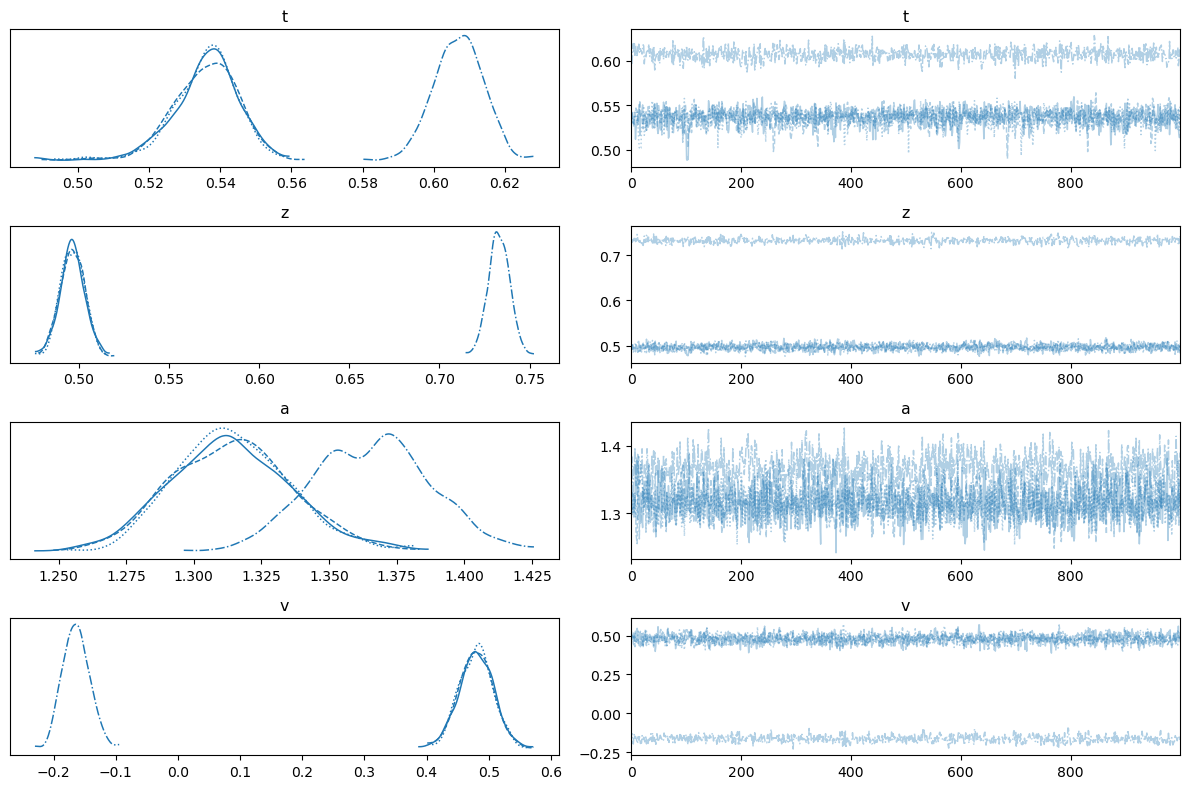

In [45]:
az.plot_trace(model_res['pooled_approx'])
plt.tight_layout()

In [23]:
# Here, I am going to define my models:

pooled_base = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response']] ,
)

pooled_v = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'zrpe', 'zpm']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + zrpe + zpm",
            "link": "identity",
        },
    ],
)


hier_v = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1|subj_idx)",
            "link": "identity",
        },
    ],
)

hier_v_rpe_pm_randint = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe', 'zpm']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1|subj_idx) + zrpe + zpm",
            "link": "identity",
        },
    ],
)

hier_v_rpe_pm_randslope = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe', 'zpm']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + zrpe + zpm|subj_idx) + zrpe + zpm",
            "link": "identity",
        },
    ],
)

model_types = {'pooled_base':pooled_base,
               'pooled_v':pooled_v, 
               'hier_v':hier_v,  
               'hier_v_rpe_pm_randint':hier_v_rpe_pm_randint,
               'hier_v_rpe_pm_randslope':hier_v_rpe_pm_randslope}

#     loglik_kind="approx_differentiable",


In [6]:
hier_v_rpe_pm_randslope.model

       Formula: c(rt, response) ~ 1 + (1 + zrpe + zpm|subj_idx) + zrpe + zpm
        Family: SSM Family
          Link: v = identity
  Observations: 10312
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            zrpe ~ Normal(mu: 0.0, sigma: 2.5)
            zpm ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            1|subj_idx ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
            zrpe|subj_idx ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
            zpm|subj_idx ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
        
        Auxiliary parameters
            t ~ HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
            a ~ HalfNormal(sigma: 2.0)
            z ~ Uniform(lower: 0.0, upper: 1.0)

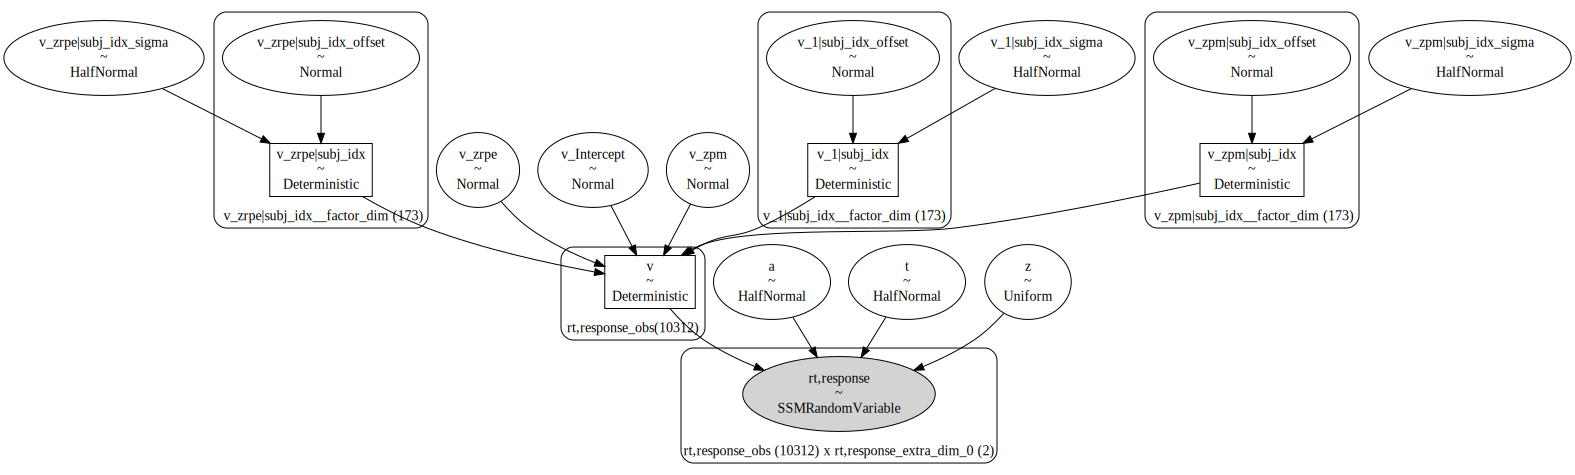

In [5]:
hier_v_rpe_pm_randslope.graph()

In [ ]:
if __name__ == "__main__":
    model_res = {f'{x}':[] for x in model_types.keys()}

    output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

    for model_key, model in model_types.items(): 
        idata = model.sample(
            sampler='nuts_numpyro',
            chains = 4,
            cores = 4,
            draws = 5000,
            tune = 5000,
            idata_kwargs=dict(log_likelihood=True))

        az.to_netcdf(idata, f"{output_dir}/{model_key}_model")

        model_res[model_key] = idata

    df_comp_loo = az.compare(model_res, ic='loo')

Compiling...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Compilation time = 0:01:02.278540
Sampling...
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/elemwise.py:43: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/scalar.py:174: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for mor

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

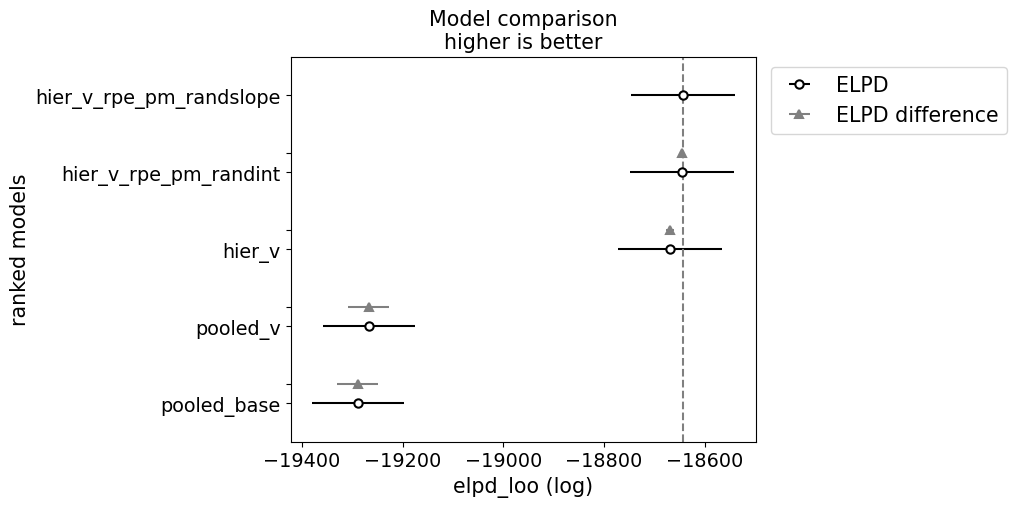

In [6]:
az.plot_compare(df_comp_loo)


The randint and randslope models are roughly equivalent! I will stick with randint because it is way less parameters

In [21]:
# Load the models: 
model_res = {f'{x}':[] for x in model_types.keys()}

output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

for model_key, model in model_types.items(): 
    idata = az.from_netcdf(f"{output_dir}/{model_key}_model")
    model_res[model_key] = idata

In [ ]:
# Save out the model comparison
az.plot_compare(df_comp_loo)

In [22]:
# az.plot_forest(infer_data_model1_hierarchical)
az.plot_trace(model_res['hier_v_rpe_pm_randslope'])
plt.tight_layout()

KeyError: 'hier_v_rpe_pm_randslope'

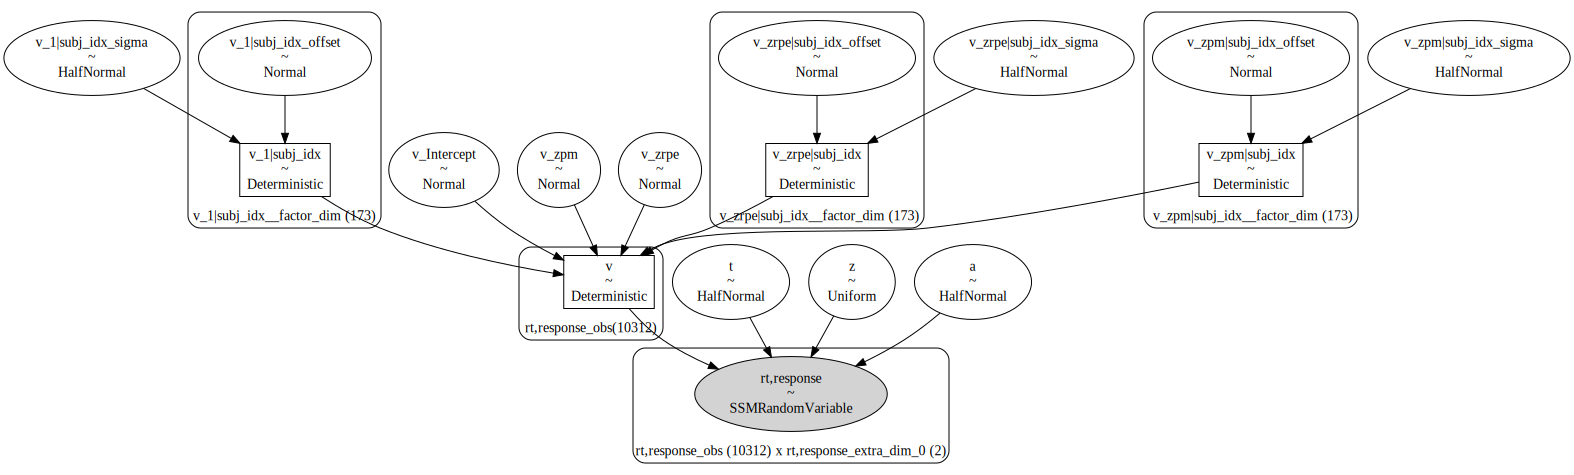

In [19]:
hier_v_rpe_pm_randslope.graph()

Now, let's check a model with just RPE vs. just PM to see what better explains the dat: 

In [124]:
hier_v_rpe_randslope = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + zrpe|subj_idx) + zrpe",
            "link": "identity",
        },
    ],
)

hier_v_pm_randslope = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zpm']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + zpm|subj_idx) + zpm",
            "link": "identity",
        },
    ],
)

model_types = {
               'hier_v_rpe_randslope':hier_v_rpe_randslope,
               'hier_v_pm_randslope':hier_v_pm_randslope
}


        # {
        #     "name": "a",
        #     "formula": "a ~ 1 + (1|subj_idx)",
        #     "link": "identity",
        # },
        # {
        #     "name": "t",
        #     "formula": "t ~ 1 + (1|subj_idx)",
        #     "link": "identity",
        # },
        # {
        #     "name": "z",
        #     "formula": "z ~ 1 + (1|subj_idx)",
        #     "link": "identity",
        # },

In [6]:
graphviz = hier_v_rpe_randslope.graph()
figsize= [5, 5]
width, height = (None, None) if figsize is None else figsize
name = f'{save_dir_plots}/DDMModelViz'
dpi=300
fmt = 'pdf'
if name is not None:
    graphviz_ = graphviz.copy()
    graphviz_.graph_attr.update(size=f"{width},{height}!")
    graphviz_.graph_attr.update(dpi=str(dpi))
    graphviz_.render(filename=name, format=fmt, cleanup=True)

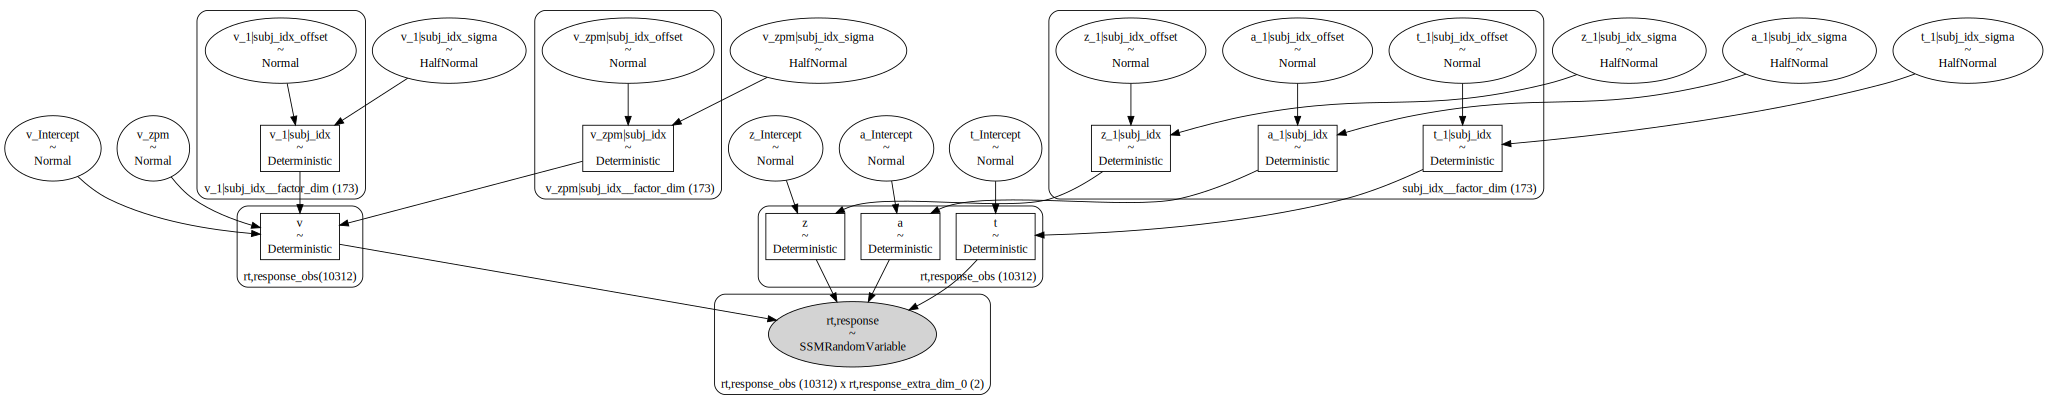

In [7]:
hier_v_pm_randslope.graph()

In [38]:
f"{output_dir}/{model_key}_model"

'/sc/arion/projects/guLab/Salman/Prolific/hier_v_rpe_randslope_model'

In [113]:
if __name__ == "__main__":
    model_res = {f'{x}':[] for x in model_types.keys()}

    output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

    for model_key, model in model_types.items(): 
        idata = model.sample(
            sampler='nuts_numpyro',
            chains = 4,
            cores = 4,
            draws = 4000,
            tune = 4000,
            idata_kwargs=dict(log_likelihood=True))

        az.to_netcdf(idata, f"{output_dir}/{model_key}_model")

        model_res[model_key] = idata

    df_comp_loo = az.compare(model_res, ic='waic')

Compiling...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Compilation time = 0:00:08.996914
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 0:57:58.963695
Transforming variables...
Transformation time = 0:00:00.309409
Computing Log Likelihood...
Log Likelihood time = 0:00:34.674891
Compiling...
Compilation time = 0:00:03.595913
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time = 1:21:08.063445
Transforming variables...
Transformation time = 0:00:00.248583
Computing Log Likelihood...
Log Likelihood time = 0:00:34.762295


In [125]:
model_res = {f'{x}':[] for x in model_types.keys()}

output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

for model_key, model in model_types.items(): 
    idata = az.from_netcdf(f"{output_dir}/{model_key}_model")
    model_res[model_key] = idata

In [38]:
df_comp_loo = az.compare(model_res, ic='waic')

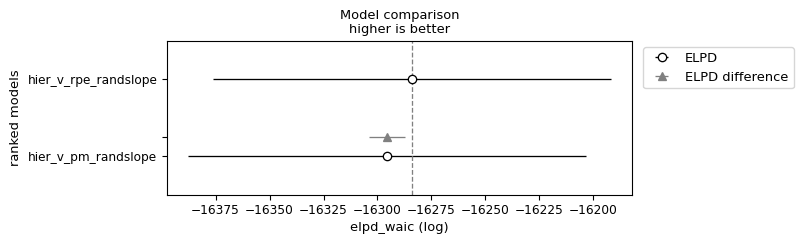

In [39]:
az.plot_compare(df_comp_loo)
plt.savefig(f'{save_dir_plots}/ddm_model_comparison_rpe_pm.pdf', dpi=300)


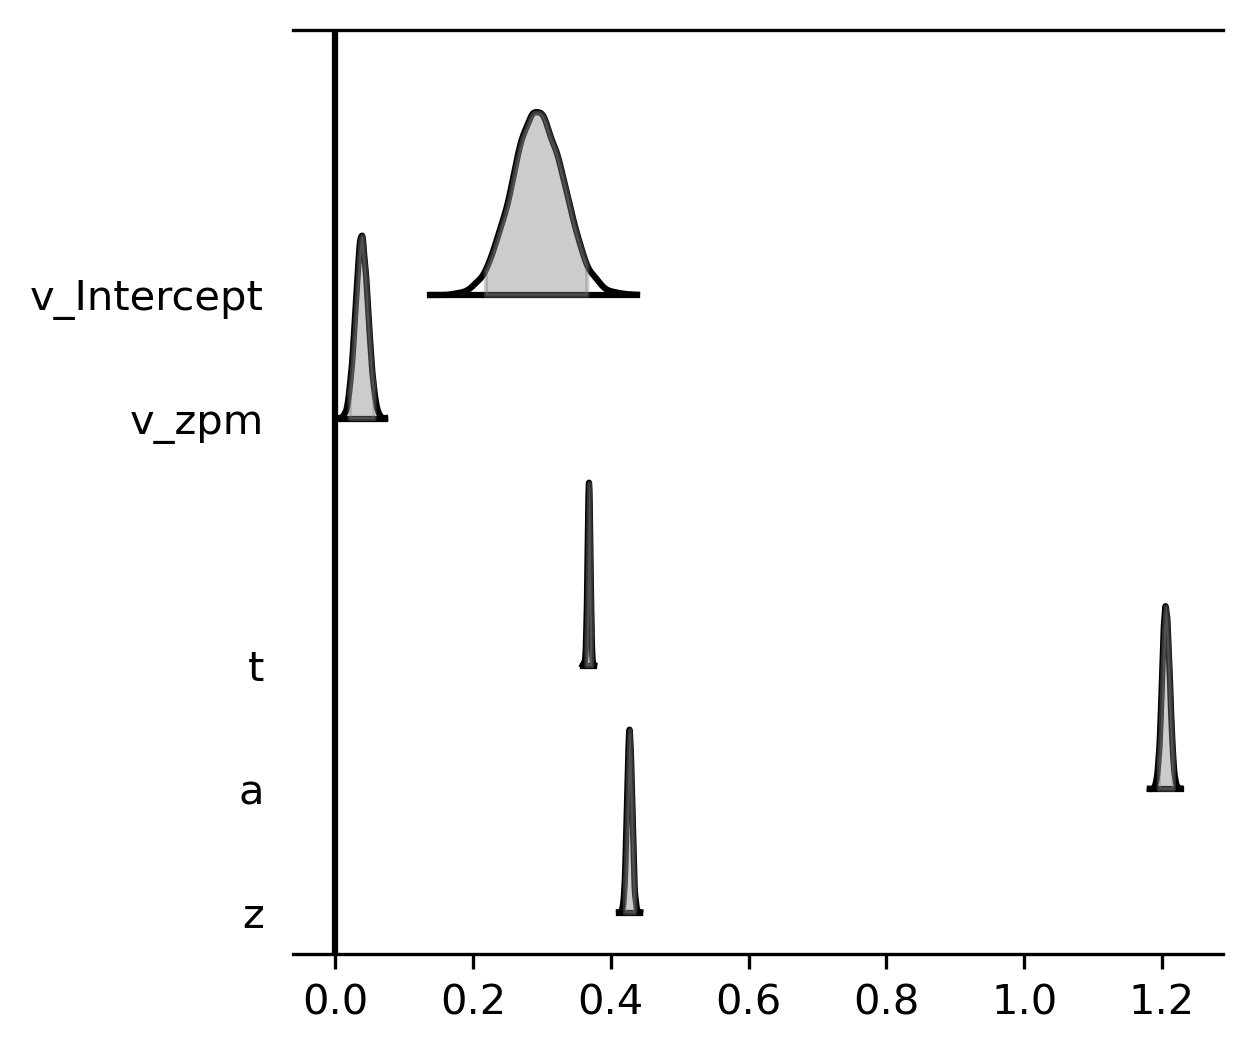

In [19]:
X = ['v_zpm', 't', 'a', 'z']
f, ax = plt.subplots(1,1, dpi=300, figsize=(4,4))
axes = az.plot_forest(model_res['hier_v_pm_randslope'],
                       kind='ridgeplot',
                       var_names=[f'^(?!.*\|).*{x}.*$' for x in X],
                       filter_vars="regex",
                       colors='gray',
                       combined=True,
                       ridgeplot_overlap=2,
                       ridgeplot_truncate=False,
                       ridgeplot_alpha=0.4,
                       hdi_prob=0.95,
                       ax=ax)
# 'forestplot'
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color = 'black')

In [130]:
az.plot_forest?

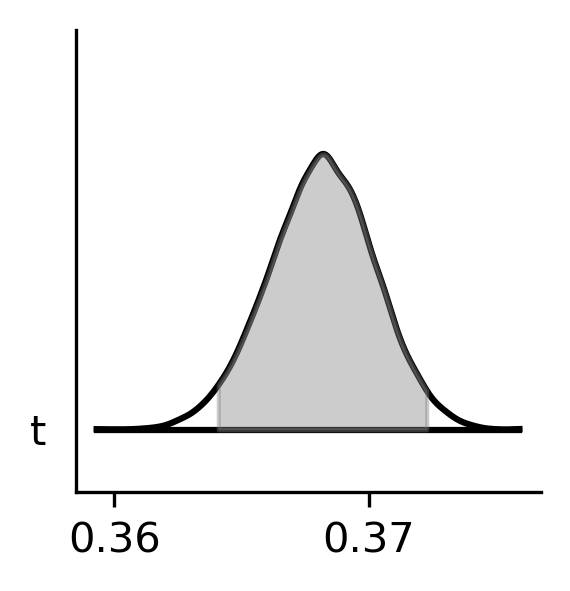

In [138]:
with PdfPages(f'{save_dir_plots}/Exp1_DDM_t_posterior.pdf') as pdf:    
    X = ['t']
    f, ax = plt.subplots(1,1, dpi=300, figsize=(2,2))
    axes = az.plot_forest(model_res['hier_v_rpe_randslope'],
                           kind='ridgeplot',
                           var_names=X, #[f'^(?!.*\|).*{x}.*$' for x in X],
                           filter_vars=None, #"regex",
                           colors='gray',
                           combined=True,
                           ridgeplot_overlap=2,
                           ridgeplot_truncate=False,
                           ridgeplot_alpha=0.4,
                           hdi_prob=0.95,
                           ax=ax)
    # axes = az.plot_forest(model_res['hier_v_pm_randslope'],
    #                        kind='forestplot',
    #                        var_names=[f'^(?!.*\|).*{x}.*$' for x in X],
    #                        filter_vars="regex",
    #                        colors='red',
    #                        combined=True,
    #                        ridgeplot_overlap=2,
    #                        ridgeplot_truncate=False,
    #                        ridgeplot_alpha=0.4,
    #                        hdi_prob=0.95,
    #                        ax=ax)

#     ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color = 'black')
    ax.set(xlim=)
    sns.despine()
    pdf.savefig()
    


In [139]:
az.summary(model_res['hier_v_rpe_randslope'])

mean     sd  hdi_3%  hdi_97%  \
v_Intercept                                0.293  0.038   0.222    0.364   
v_zrpe                                     0.046  0.011   0.025    0.067   
t                                          0.368  0.002   0.364    0.372   
a                                          1.208  0.006   1.197    1.218   
z                                          0.427  0.004   0.420    0.434   
...                                          ...    ...     ...      ...   
v_zrpe|subj_idx[6153a7dc02b0da61f715a154]  0.019  0.068  -0.105    0.152   
v_zrpe|subj_idx[61569ee5ec13f9d23135674e] -0.015  0.070  -0.151    0.115   
v_zrpe|subj_idx[615b2716e0b4b77a886bdf23] -0.034  0.073  -0.173    0.102   
v_zrpe|subj_idx[615d7e681c930db4365ca2d0] -0.017  0.061  -0.137    0.093   
v_zrpe|subj_idx[6234c5022749fad8f79fee49] -0.010  0.063  -0.131    0.109   

                                           mcse_mean  mcse_sd  ess_bulk  \
v_Intercept                                    0.001    0.001    1153.0   
v_zrpe                                         0.000    0.000   11500.0   
t                                              0.000    0.000   18823.0   
a                                              0.000    0.000   18166.0   
z                                              0.000    0.000   16078.0   
...                                              ...      ...       ...   
v_zrpe|subj_idx[6153a7dc02b0da61f715a154]      0.000    0.001   19166.0   
v_zrpe|subj_idx[61569ee5ec13f9d23135674e]      0.000    0.001   19910.0   
v_zrpe|subj_idx[615b2716e0b4b77a886bdf23]      0.001    0.001   18000.0   
v_zrpe|subj_idx[615d7e681c930db4365ca2d0]      0.000    0.000   20574.0   
v_zrpe|subj_idx[6234c5022749fad8f79fee49]      0.000    0.000   19915.0   

                                           ess_tail  r_hat  
v_Intercept                                  2532.0    1.0  
v_zrpe                                      11594.0    1.0  
t                                           10969.0    1.0  
a                                           11720.0    1.0  
z                                           12291.0    1.0  
...                                             ...    ...  
v_zrpe|subj_idx[6153a7dc02b0da61f715a154]   11658.0    1.0  
v_zrpe|subj_idx[61569ee5ec13f9d23135674e]   11846.0    1.0  
v_zrpe|subj_idx[615b2716e0b4b77a886bdf23]   12244.0    1.0  
v_zrpe|subj_idx[615d7e681c930db4365ca2d0]   12025.0    1.0  
v_zrpe|subj_idx[6234c5022749fad8f79fee49]   12541.0    1.0  

[353 rows x 9 columns]

In [140]:
az.summary(model_res['hier_v_pm_randslope'])

mean     sd  hdi_3%  hdi_97%  \
v_Intercept                               0.294  0.038   0.223    0.365   
v_zpm                                     0.038  0.009   0.021    0.056   
t                                         0.368  0.002   0.364    0.372   
a                                         1.206  0.006   1.196    1.217   
z                                         0.427  0.004   0.420    0.434   
...                                         ...    ...     ...      ...   
v_zpm|subj_idx[6153a7dc02b0da61f715a154] -0.000  0.027  -0.055    0.054   
v_zpm|subj_idx[61569ee5ec13f9d23135674e]  0.002  0.028  -0.050    0.064   
v_zpm|subj_idx[615b2716e0b4b77a886bdf23]  0.000  0.029  -0.061    0.058   
v_zpm|subj_idx[615d7e681c930db4365ca2d0] -0.000  0.027  -0.055    0.058   
v_zpm|subj_idx[6234c5022749fad8f79fee49] -0.004  0.027  -0.059    0.050   

                                          mcse_mean  mcse_sd  ess_bulk  \
v_Intercept                                   0.001    0.001    2600.0   
v_zpm                                         0.000    0.000   37214.0   
t                                             0.000    0.000   31123.0   
a                                             0.000    0.000   30099.0   
z                                             0.000    0.000   32547.0   
...                                             ...      ...       ...   
v_zpm|subj_idx[6153a7dc02b0da61f715a154]      0.000    0.000   31462.0   
v_zpm|subj_idx[61569ee5ec13f9d23135674e]      0.000    0.000   29937.0   
v_zpm|subj_idx[615b2716e0b4b77a886bdf23]      0.000    0.000   31513.0   
v_zpm|subj_idx[615d7e681c930db4365ca2d0]      0.000    0.000   31723.0   
v_zpm|subj_idx[6234c5022749fad8f79fee49]      0.000    0.000   28510.0   

                                          ess_tail  r_hat  
v_Intercept                                 5107.0    1.0  
v_zpm                                      11402.0    1.0  
t                                          11679.0    1.0  
a                                          11773.0    1.0  
z                                          12728.0    1.0  
...                                            ...    ...  
v_zpm|subj_idx[6153a7dc02b0da61f715a154]   12846.0    1.0  
v_zpm|subj_idx[61569ee5ec13f9d23135674e]   11992.0    1.0  
v_zpm|subj_idx[615b2716e0b4b77a886bdf23]   11486.0    1.0  
v_zpm|subj_idx[615d7e681c930db4365ca2d0]   11694.0    1.0  
v_zpm|subj_idx[6234c5022749fad8f79fee49]   11867.0    1.0  

[353 rows x 9 columns]

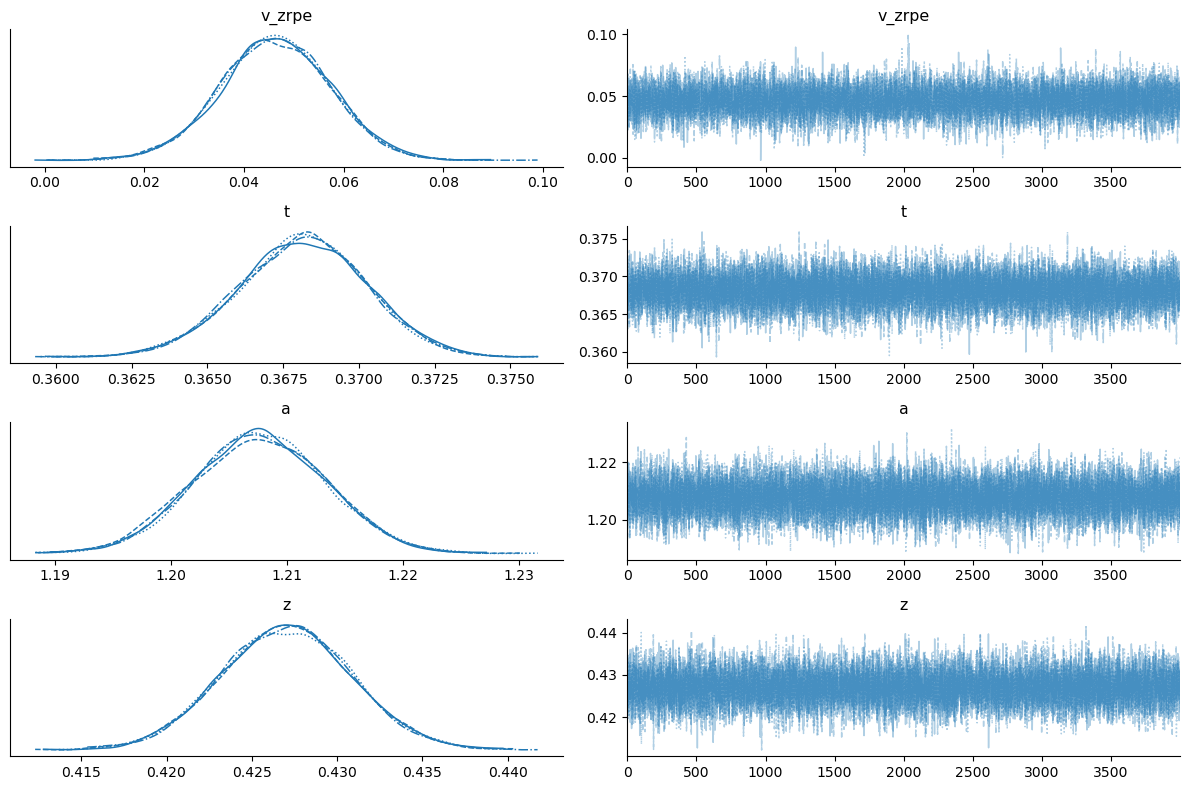

In [35]:
with PdfPages(f'{save_dir_plots}/Exp1_DDM_RPE.pdf') as pdf:    
    az.plot_trace(model_res['hier_v_rpe_randslope'], 
                  var_names =['v_zrpe', 't', 'a', 'z'])
    plt.tight_layout()
    sns.despine()
    pdf.savefig()


In [40]:
def drift_diffusion_plot(values, upperbound, lowerbound, 
                         upperlabel='', lowerlabel='', 
                         stickybounds=True, **kwargs):
    """
    Creates a formatted drift-diffusion plot for a given timeseries.
    
    Inputs:
       - values: array of values in timeseries
       - upperbound: numeric value of upper bound
       - lowerbound: numeric value of lower bound
       - upperlabel: optional label for upper bound
       - lowerlabel: optional label for lower bound
       - stickybounds: if true, timeseries stops when bound is hit
       - kwargs: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html
    
    Output:
       - ax: handle to plot axis
    """
    
    #if bounds are sticky, hide timepoints that follow the first bound hit
    if stickybounds:
        #check to see if (and when) a bound was hit
        bound_hits = np.where((values>upperbound) | (values<lowerbound))[0]
        #if a bound was hit, replace subsequent values with NaN
        if len(bound_hits)>0:
            values = values.copy()
            values[bound_hits[0]+1:] = np.nan
    
    #plot timeseries
    ax = plt.gca()
    plt.plot(values, **kwargs)
    
    #format plot
    ax.set_ylim(lowerbound, upperbound)
    ax.set_yticks([lowerbound,upperbound])
    ax.set_yticklabels([lowerlabel,upperlabel])
    ax.axhline(y=np.mean([upperbound, lowerbound]), color='lightgray', zorder=0)
    ax.set_xlim(0,len(values))
    ax.set_xlabel('time')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

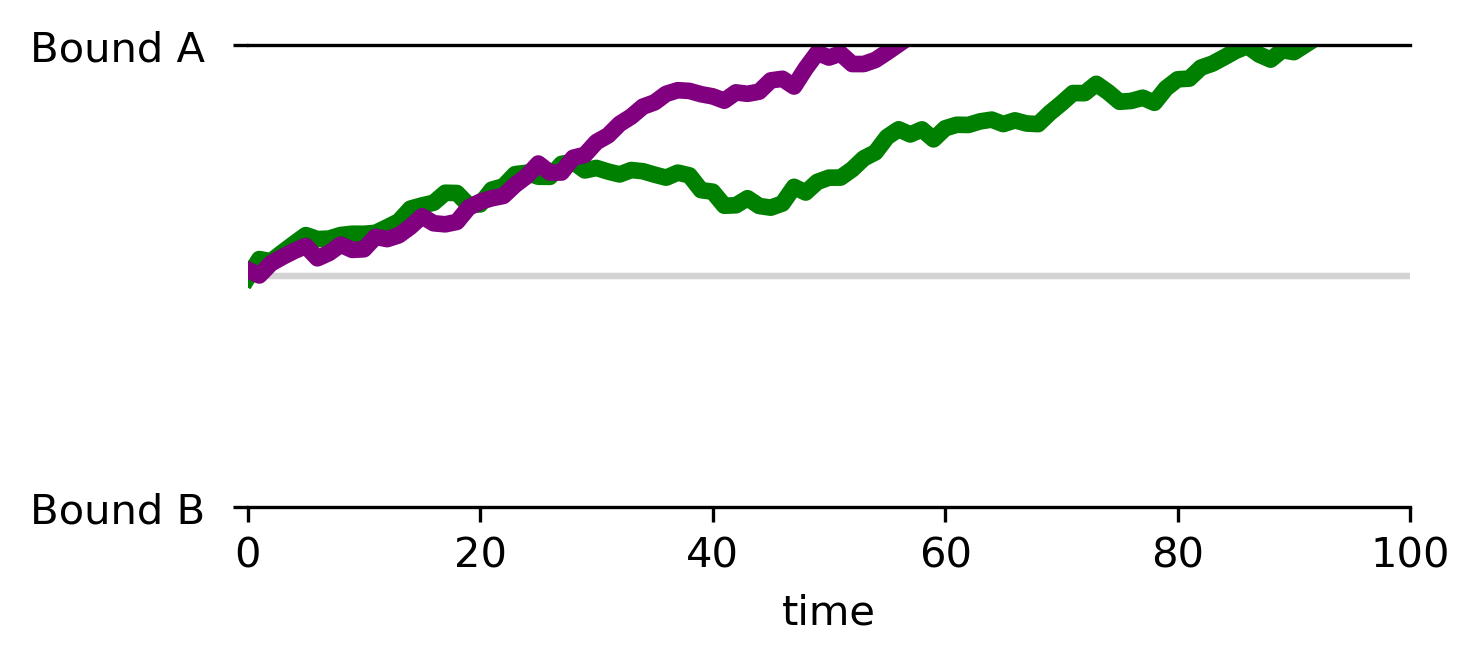

In [107]:
with PdfPages(f'{save_dir_plots}/Exp1_DDM_schematic.pdf') as pdf:    
    f, ax = plt.subplots(1,1, dpi=300, figsize=(5,2))
    
    n=10

    #group 1 (positive drift)
    data1 = pd.DataFrame(np.reshape(np.cumsum(np.random.randn(t,n)+0.1,axis=0),(t,n)))
#     data1.apply(drift_diffusion_plot, upperbound=10, lowerbound=-10, 
#                 color='g', alpha=0.3);

    #group 2 (negative drift)
    data2 = pd.DataFrame(np.reshape(np.cumsum(np.random.randn(t,n)+0.12,axis=0),(t,n)))
#     data2.apply(drift_diffusion_plot, upperbound=10, lowerbound=-10, 
#                 color='purple', alpha=0.3);

    #overlay means
    drift_diffusion_plot(np.mean(data1, axis=1), upperbound=10, lowerbound=-10,
                         color='g', lw=4, alpha=1);
    drift_diffusion_plot(np.mean(data2, axis=1), upperbound=10, lowerbound=-10, 
                         upperlabel='Bound A ', lowerlabel='Bound B ', 
                         color='purple', lw=4, alpha=1);
    pdf.savefig()

Let's do some posterior predictive checks and simulation to see if the job is actually doing a good job fitting the data:

https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html

In [24]:
pm_model_idata = az.from_netcdf(f"{output_dir}/hier_v_pm_randslope_model")


In [27]:
pm_model_idata.posterior['v_zpm'].mean().values

array(0.03643491, dtype=float32)

In [23]:
rpe_model_idata.posterior['v_zrpe'].mean().values

array(0.04680782, dtype=float32)

In [198]:
output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

rpe_model_idata = az.from_netcdf(f"{output_dir}/hier_v_rpe_randslope_model")

rpe_model = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + zrpe|subj_idx) + zrpe",
            "link": "identity",
        },
    ],
)

In [199]:
# Is there any relation between DDM parameters and F1 score

In [209]:
df['f1_score'] = np.nan
df['v_zrpe'] = np.nan
for ix, pid in enumerate(df.groupby('subj_idx').mean().reset_index().subj_idx.values):
    df.loc[df.subj_idx==pid, 'f1_score'] = f1_score[ix]
    df.loc[df.subj_idx==pid, 'v_zrpe'] = rpe_model_idata.posterior['v_zrpe|subj_idx'].mean(axis=0).mean(axis=0)[ix]


<Axes: xlabel='f1_score', ylabel='v_zrpe'>

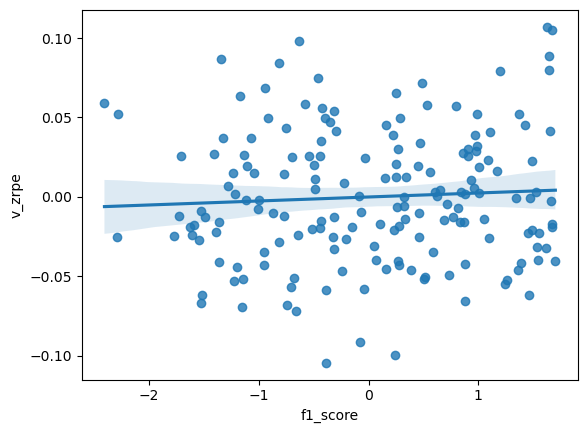

In [214]:
sns.regplot(data=df.groupby('subj_idx').mean().reset_index(), x='f1_score', y='v_zrpe')

(array([ 1.,  0.,  0.,  1.,  5., 22., 76., 53., 11.,  4.]),
 array([-2.48138618e+00, -2.06784534e+00, -1.65430462e+00, -1.24076378e+00,
        -8.27222943e-01, -4.13682163e-01, -1.41358381e-04,  4.13399458e-01,
         8.26940238e-01,  1.24048102e+00,  1.65402186e+00]),
 <BarContainer object of 10 artists>)

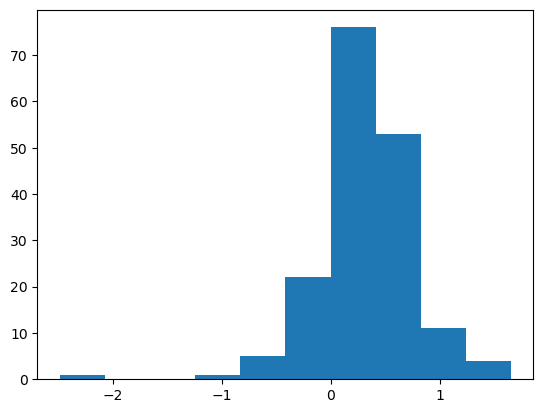

In [91]:
plt.hist(v)

In [19]:
_model = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe']] ,
)
_model.model

       Formula: c(rt, response) ~ 1
        Family: SSM Family
          Link: v = identity
  Observations: 9831
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.0)
        
        Auxiliary parameters
            t ~ HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
            z ~ Uniform(lower: 0.0, upper: 1.0)
            a ~ HalfNormal(sigma: 2.0)

In [121]:
rpe_model = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe']] ,
)
rpe_model.model

       Formula: c(rt, response) ~ 1
        Family: SSM Family
          Link: v = identity
  Observations: 9831
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.0)
        
        Auxiliary parameters
            z ~ Uniform(lower: 0.0, upper: 1.0)
            t ~ HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
            a ~ HalfNormal(sigma: 2.0)

In [111]:
rpe_model_idata.posterior['v_1|subj_idx'].min()

<xarray.DataArray 'v_1|subj_idx' ()>
array(-3.75108314)

In [125]:
idata.posterior['v_Intercept'].mean(axis=0).mean(axis=0)

<xarray.DataArray 'v_Intercept' ()>
array(0.18742041)

In [149]:
# Simulate some data
from ssms.basic_simulators import simulator

# Specify parameters
# v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.2]
sim_dfs = []


sim_a = [] 
sim_t = []
sim_z = []
sim_v = []

n_sub = 25
n_sim = 50

# Set a seed so i know what the original values are
np.random.seed(0)
a = np.abs(np.random.normal(loc=0, scale=1, size=n_sim))
# t: [0.2, 0.5]
t = np.abs(np.random.normal(loc=0, scale=1, size=n_sim))
t[t<0.1] = 0.1
# z: [0,1]
z = np.random.beta(a=1.2, b=1.2, size=n_sim)
# vrpe: [0,1]
# Intercept = np.random.uniform(low=rpe_model_idata.posterior['v_Intercept'].min(), high=rpe_model_idata.posterior['v_Intercept'].max()*2, size=n_sim)
# zrpe = np.random.uniform(low=rpe_model_idata.posterior['v_zrpe'].min(), high=rpe_model_idata.posterior['v_zrpe'].max()*2, size=n_sim)
# rand_subj = np.random.normal(loc=0, scale=2.5, size=[n_sub, n_sim])
# rpe_subj = np.random.normal(loc=0, scale=0.5, size=[n_sub, n_sim])
v = np.random.normal(loc=0, scale=2, size=n_sim)


# Intercept = np.random.normal(loc=0, scale=2, size=100)

for sim in range(n_sim):
    print(sim)
    sim_dfs = [] 
    for ix, subj in enumerate(df.subj_idx.unique()[:n_sub]):
        
        # Simulate data by sampling from the posterior of the "true" parameter estimates
        sim_out = simulator(
            theta=[v[sim], 
                   a[sim], 
                   z[sim], 
                   t[sim]],  # parameter list
            model="ddm",  # specify model (many are included in ssms)
            n_samples=len(df[df.subj_idx==subj].zrpe.values),  # number of samples for each set of parameters
        )

        # Turn data into a pandas dataframe
        dataset = pd.DataFrame(
            np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
            columns=["rt", "response"],
        )
        dataset['zrpe'] = df[df.subj_idx==subj].zrpe.values
        dataset['subj_idx'] = subj

        sim_dfs.append(dataset)
    sim_df = pd.concat(sim_dfs)


    rpe_model = hssm.HSSM(
        model="ddm",
        p_outlier = None,
        lapse = None, 
        data=sim_df[['rt', 'response', 'subj_idx', 'zrpe']] ,
        include=[
            {
                "name": "v",
                "formula": "v ~ 1 + (1 + zrpe|subj_idx) + zrpe",
                "link": "identity",
            },
        ],
    )

    idata = rpe_model.sample(
        sampler='nuts_numpyro',
        chains = 4,
        cores = 4,
        draws = 1000,
        tune = 4000,
        idata_kwargs=dict(log_likelihood=False))

    sim_a.append(idata['posterior']['a'].mean().values)
    sim_t.append(idata['posterior']['t'].mean().values)
    sim_z.append(idata['posterior']['z'].mean().values)
    sim_v.append(idata['posterior']['v_Intercept'].mean().values)

    # Open the file in append mode and write the lists
    with open('/sc/arion/projects/guLab/Salman/Prolific/ddm_param_recovery.txt', 'a') as file:
        file.write(f"sim_a: {sim_a}\n")
        file.write(f"sim_t: {sim_t}\n")
        file.write(f"sim_z: {sim_z}\n")
        file.write(f"sim_v: {sim_v}\n")


Compiling...


0


Compilation time = 0:00:04.683497
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:14:39.780979
Transforming variables...
Transformation time = 0:00:00.465479


1


Compiling...
Compilation time = 0:00:10.876586
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:25:02.168517
Transforming variables...
Transformation time = 0:00:00.210287
Compiling...


2


Compilation time = 0:00:04.386563
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:06:55.408743
Transforming variables...
Transformation time = 0:00:00.204341


3


Compiling...
Compilation time = 0:00:06.020216
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:40.167786
Transforming variables...
Transformation time = 0:00:00.204324


4


Compiling...
Compilation time = 0:00:04.364351
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:06:30.196529
Transforming variables...
Transformation time = 0:00:00.201014
Compiling...


5


Compilation time = 0:00:04.368706
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:08:27.777369
Transforming variables...
Transformation time = 0:00:00.207498
Compiling...


6


Compilation time = 0:00:04.090218
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:46.492094
Transforming variables...
Transformation time = 0:00:00.208515
Compiling...


7


Compilation time = 0:00:06.354580
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:10:22.373402
Transforming variables...
Transformation time = 0:00:00.213358
Compiling...


8


Compilation time = 0:00:04.330075
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 1:09:56.838134
Transforming variables...
Transformation time = 0:00:00.209147
Compiling...


9


Compilation time = 0:00:06.087610
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:51.565183
Transforming variables...
Transformation time = 0:00:00.205037
Compiling...


10


Compilation time = 0:00:04.097149
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:27:41.392050
Transforming variables...
Transformation time = 0:00:00.209861
Compiling...


11


Compilation time = 0:00:06.566945
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:07:39.514846
Transforming variables...
Transformation time = 0:00:00.209819
Compiling...


12


Compilation time = 0:00:04.152620
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:19.793430
Transforming variables...
Transformation time = 0:00:00.201618
Compiling...


13


Compilation time = 0:00:06.194541
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 1:40:40.766543
Transforming variables...
Transformation time = 0:00:00.204435
Compiling...


14


Compilation time = 0:00:04.136521
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:22.528865
Transforming variables...
Transformation time = 0:00:00.203562


15


Compiling...
Compilation time = 0:00:04.085295
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:42.144711
Transforming variables...
Transformation time = 0:00:00.210488


16


Compiling...
Compilation time = 0:00:06.479385
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:05.828937
Transforming variables...
Transformation time = 0:00:00.214735
Compiling...


17


Compilation time = 0:00:04.445968
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:20:08.307846
Transforming variables...
Transformation time = 0:00:00.217919
Compiling...


18


Compilation time = 0:00:06.880230
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:27:50.506063
Transforming variables...
Transformation time = 0:00:00.228242
Compiling...


19


Compilation time = 0:00:04.441269
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:33.039824
Transforming variables...
Transformation time = 0:00:00.215579


20


Compiling...
Compilation time = 0:00:07.642315
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:05:18.216429
Transforming variables...
Transformation time = 0:00:00.217730
Compiling...


21


Compilation time = 0:00:04.481103
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:04.144554
Transforming variables...
Transformation time = 0:00:00.218017
Compiling...


22


Compilation time = 0:00:07.047573
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:26.325989
Transforming variables...
Transformation time = 0:00:00.219851
Compiling...


23


Compilation time = 0:00:04.690578
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:06:28.362998
Transforming variables...
Transformation time = 0:00:00.204871


24


Compiling...
Compilation time = 0:00:04.350032
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:32.588217
Transforming variables...
Transformation time = 0:00:00.217494


25


Compiling...
Compilation time = 0:00:04.358769
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:09.655696
Transforming variables...
Transformation time = 0:00:00.216275
Compiling...


26


Compilation time = 0:00:06.834821
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 1:55:54.022140
Transforming variables...
Transformation time = 0:00:00.203653
Compiling...


27


Compilation time = 0:00:04.180645
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:08:38.581390
Transforming variables...
Transformation time = 0:00:00.211354


28


Compiling...
Compilation time = 0:00:06.504659
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:17.443152
Transforming variables...
Transformation time = 0:00:00.207837
Compiling...


29


Compilation time = 0:00:04.342768
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:06:13.426659
Transforming variables...
Transformation time = 0:00:00.214262
Compiling...


30


Compilation time = 0:00:04.132015
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:17:13.630837
Transforming variables...
Transformation time = 0:00:00.205513
Compiling...


31


Compilation time = 0:00:04.200265
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:09:18.754691
Transforming variables...
Transformation time = 0:00:00.208728
Compiling...


32


Compilation time = 0:00:06.627127
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:02.004744
Transforming variables...
Transformation time = 0:00:00.204565


33


Compiling...
Compilation time = 0:00:04.220787
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:53.955548
Transforming variables...
Transformation time = 0:00:00.210263
Compiling...


34


Compilation time = 0:00:06.636310
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:30:35.219409
Transforming variables...
Transformation time = 0:00:00.204306
Compiling...


35


Compilation time = 0:00:04.220138
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:19:52.302904
Transforming variables...
Transformation time = 0:00:00.208007
Compiling...


36


Compilation time = 0:00:06.717969
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:57.004297
Transforming variables...
Transformation time = 0:00:00.209548
Compiling...


37


Compilation time = 0:00:04.216284
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:58.188236
Transforming variables...
Transformation time = 0:00:00.204064
Compiling...


38


Compilation time = 0:00:06.972812
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:05:15.685755
Transforming variables...
Transformation time = 0:00:00.216384
Compiling...


39


Compilation time = 0:00:04.225133
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:16:39.437706
Transforming variables...
Transformation time = 0:00:00.213842
Compiling...


40


Compilation time = 0:00:04.297440
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:08:07.667480
Transforming variables...
Transformation time = 0:00:00.207779


41


Compiling...
Compilation time = 0:00:07.214682
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:55.283233
Transforming variables...
Transformation time = 0:00:00.211550


42


Compiling...
Compilation time = 0:00:04.277511
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:04.303089
Transforming variables...
Transformation time = 0:00:03.130883


43


Compiling...
Compilation time = 0:00:04.343939
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:05:39.441973
Transforming variables...
Transformation time = 0:00:00.207756
Compiling...


44


Compilation time = 0:00:04.238405
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:04:08.621752
Transforming variables...
Transformation time = 0:00:00.208545
Compiling...


45


Compilation time = 0:00:06.961483
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:58:31.565350
Transforming variables...
Transformation time = 0:00:00.209140


46


Compiling...
Compilation time = 0:00:04.261888
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:14.266357
Transforming variables...
Transformation time = 0:00:00.212818
Compiling...


47


Compilation time = 0:00:06.933582
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:47:27.023240
Transforming variables...
Transformation time = 0:00:00.214108


48


Compiling...
Compilation time = 0:00:04.239851
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:03:17.662194
Transforming variables...
Transformation time = 0:00:00.211650
Compiling...


49


Compilation time = 0:00:07.034994
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:07:48.427462
Transforming variables...
Transformation time = 0:00:00.208317


In [24]:
# Load the parameter recovery

In [133]:
import re

# Specify the path to your .txt file
file_path = '/sc/arion/projects/guLab/Salman/Prolific/ddm_param_recovery.txt'

# Read the content of the file
with open(file_path, 'r') as file:
    content = file.read()

params = {'sim_a': np.nan,
          'sim_t': np.nan,
          'sim_z': np.nan,
          'sim_v': np.nan}

for p in params.keys():
    # Find the last occurrence of 'sim_a'
    last_sim_a_index = content.rfind(p)

    # Find the next occurrence of a variable starting with 'sim' after 'sim_a'
    next_sim_index = content.find('sim', last_sim_a_index + 1)

    # Extract the portion between the last 'sim_a' and the next 'sim'
    final_occurrence = content[last_sim_a_index:next_sim_index].strip()

    # Extract numbers with a '.' using regular expression
    numbers_with_dot = re.findall(r'\d+\.\d+', final_occurrence)

    # Convert the list of strings to a list of floats
    numbers_with_dot = list(map(float, numbers_with_dot))

    params[p] = numbers_with_dot


In [9]:
# # Set a seed so i know what the original values are
# np.random.seed(0)
# a = np.abs(np.random.normal(loc=0, scale=1, size=n_sim))
# # t: [0.2, 0.5]
# t = np.abs(np.random.normal(loc=0, scale=1, size=n_sim))
# t[t<0.1] = 0.1
# # z: [0,1]
# z = np.random.beta(a=1.2, b=1.2, size=n_sim)
# # vrpe: [0,1]
# Intercept = np.random.normal(loc=0, scale=2.5, size=n_sim)
# zrpe = np.random.normal(loc=0, scale=2.5, size=n_sim)
# rand_subj = np.random.normal(loc=0, scale=2.5, size=[n_sub, n_sim])
# rpe_subj = np.random.normal(loc=0, scale=2.5, size=[n_sub, n_sim])

In [163]:
save_dir_plots

'/sc/arion/projects/guLab/Salman/MemoryBanditManuscript/Figures/Exp1'

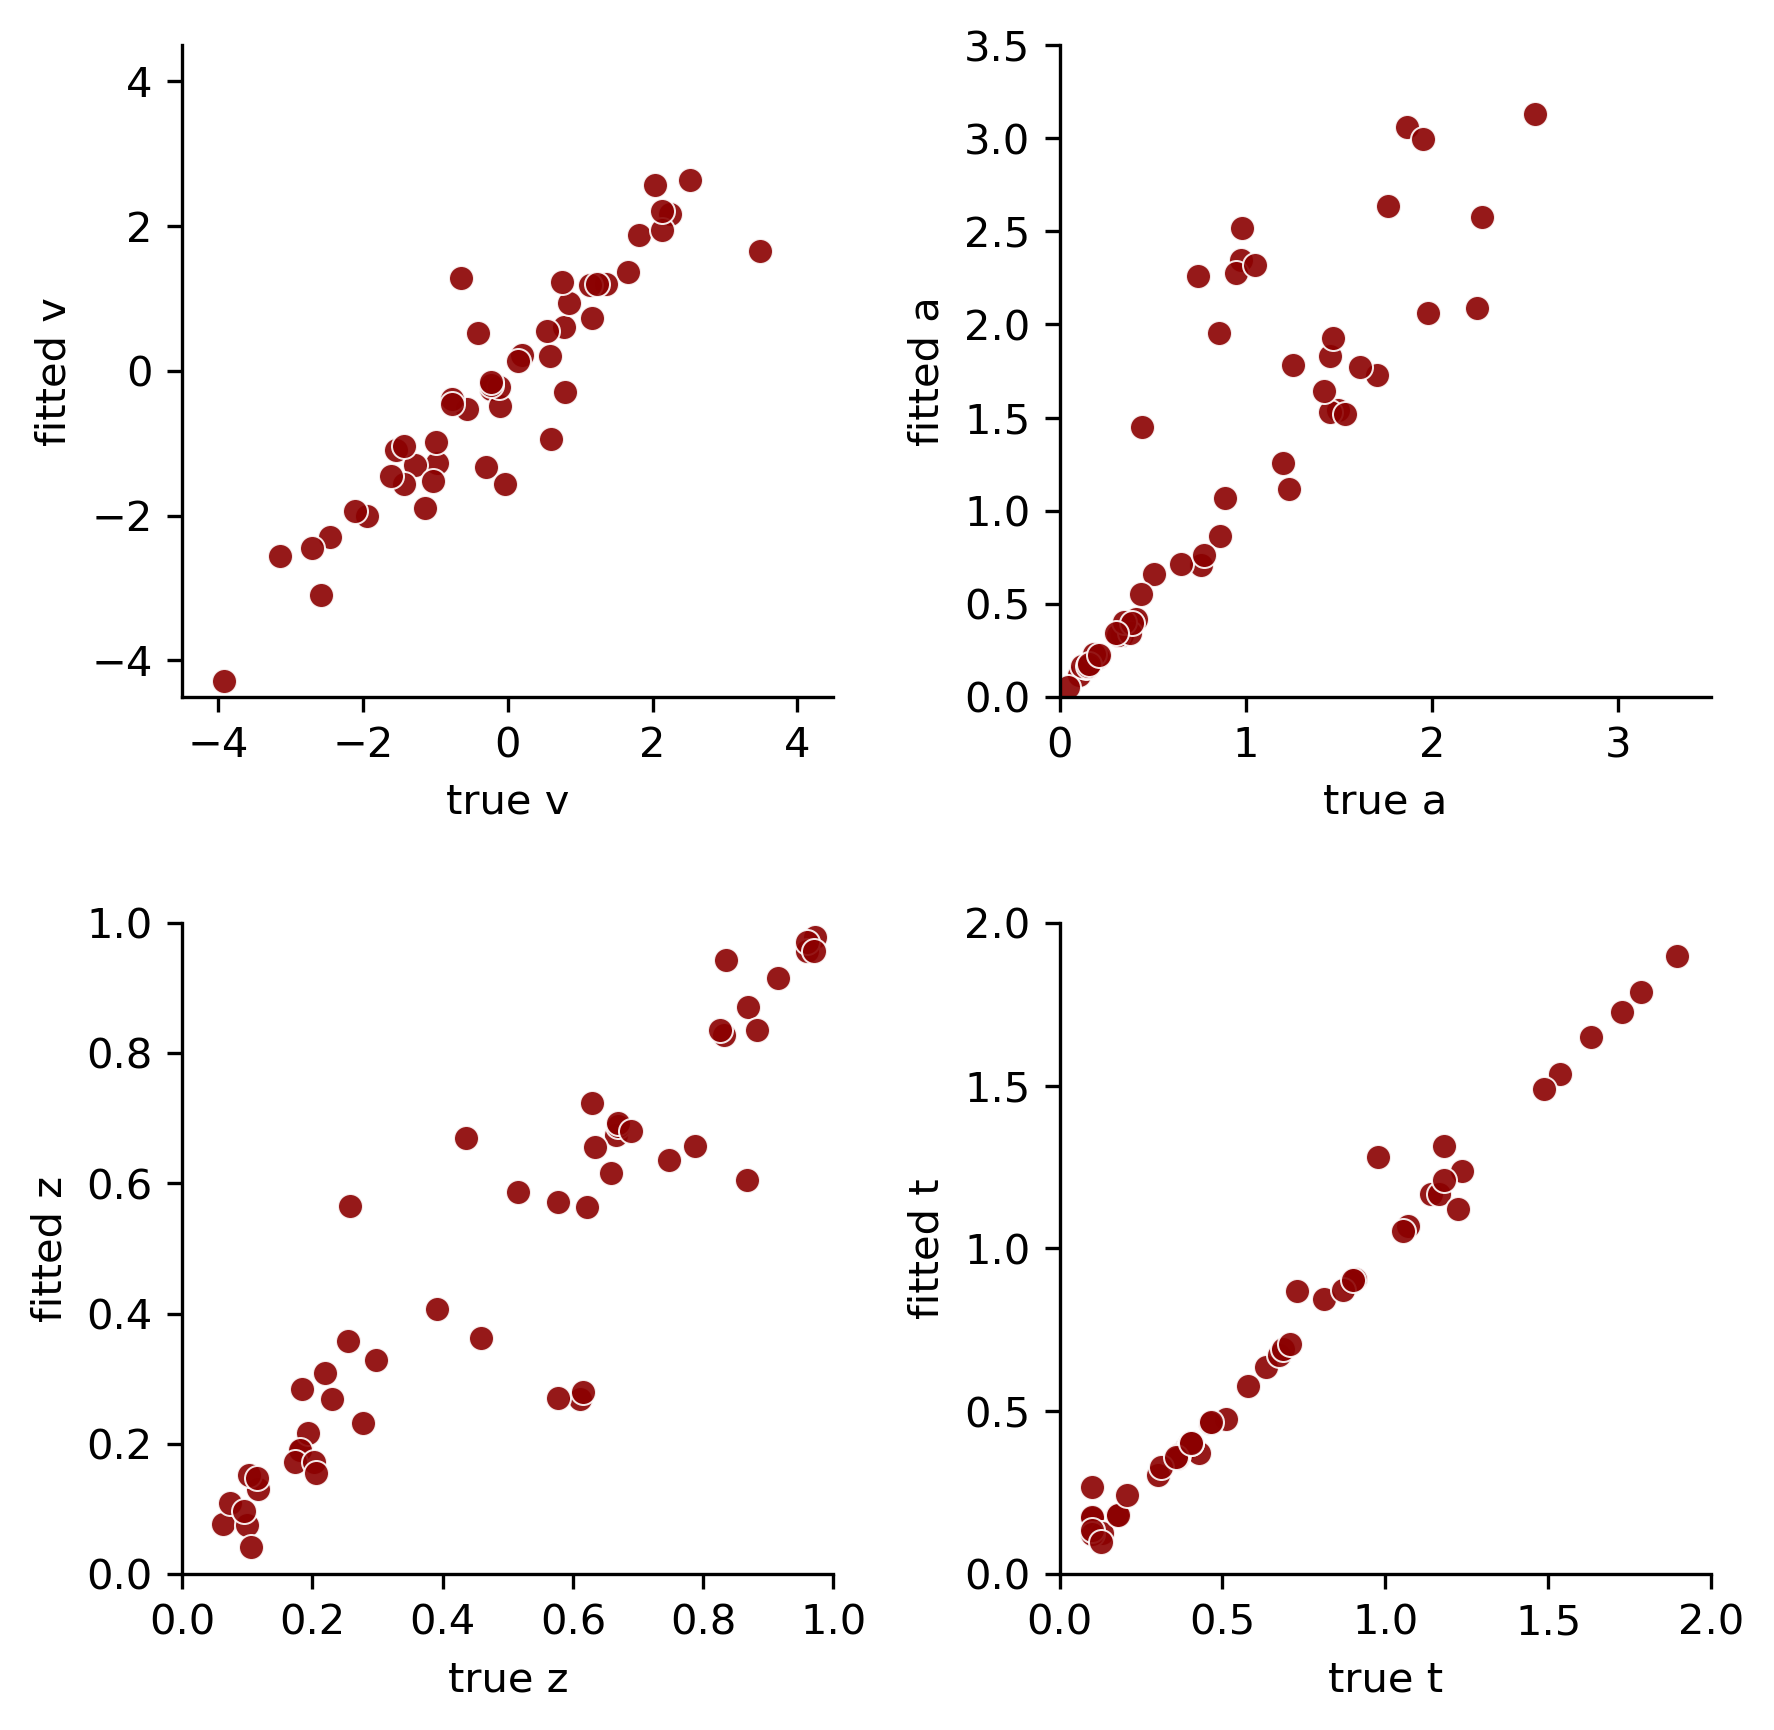

In [186]:
with PdfPages(f'{save_dir_plots}/ParameterRecovery.pdf') as pdf:    

    f, ax = plt.subplots(2,2, dpi=300, figsize=(6,6))

    sns.scatterplot(x=v, y=[float(x) for x in sim_v], ax=ax[0, 0], color='darkred', alpha = 0.9)
    ax[0, 0].set(xlabel='true v', ylabel='fitted v', xlim=[-4.5, 4.5], ylim=[-4.5, 4.5], 
                 aspect='equal', adjustable='box')
    sns.scatterplot(x=a, y=[float(x) for x in sim_a], ax=ax[0, 1], color='darkred', alpha = 0.9)
    ax[0, 1].set(xlabel='true a', ylabel='fitted a', xlim=[0, 3.5], ylim=[0, 3.5], 
                 aspect='equal', adjustable='box')
    sns.scatterplot(x=z, y=[float(x) for x in sim_z], ax=ax[1, 0], color='darkred', alpha = 0.9)
    ax[1, 0].set(xlabel='true z', ylabel='fitted z', xlim=[0, 1], ylim=[0, 1],
                 aspect='equal', adjustable='box')
    sns.scatterplot(x=t, y=[float(x) for x in sim_t], ax=ax[1, 1], color='darkred', alpha = 0.9)
    ax[1, 1].set(xlabel='true t', ylabel='fitted t', xlim=[0, 2], ylim=[0, 2],
                 aspect='equal', adjustable='box')
    f.tight_layout()
    sns.despine()
    
    pdf.savefig()

In [165]:
from scipy.stats import pearsonr

In [170]:
pearsonr(t, sim_t)

PearsonRResult(statistic=0.9929982769694206, pvalue=3.4282361758168915e-46)

Use the results from this to just plot parameter recovery for the 

In [44]:
rpe_model = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=sim_df[['rt', 'response', 'subj_idx', 'zrpe']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + zrpe|subj_idx) + zrpe",
            "link": "identity",
        },
    ],
)

In [ ]:
idata = rpe_model.sample(
    sampler='nuts_numpyro',
    chains = 4,
    cores = 4,
    draws = 5000,
    tune = 5000,
    idata_kwargs=dict(log_likelihood=True))

az.to_netcdf(idata, f"{output_dir}/hier_v_rpe_randslope_model_simulated")

Compiling...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Compilation time = 0:00:36.116794
Sampling...
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/scalar.py:174: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x).astype(op.o_type.dtype)
/hpc/users/qasims01/.local/lib/python3.11/site-packages/pytensor/link/jax/dispatch/elemwise.py:43: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

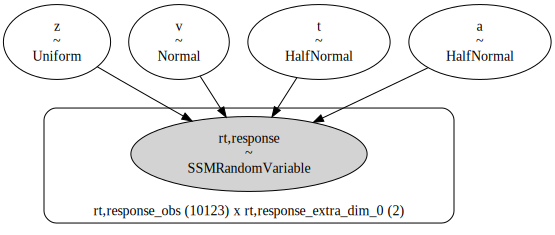

In [62]:
fully_pooled.graph()

Note #1: Fully pooled data samples perfectly and quicky using analytical likelihood and mcmc. nuts_numpyro and nuts_blackjax still doesn't work with analytical likelihood.

Note #2: If I use loglik_kind = 'approx_differentiable' and nuts_numpyro I get different posterior estimates than using loglik_kind = 'analytical' and mcmc. 

Note #3: If I use the loglike_kind = 'blackbox' to go back to hdmm likelihood and slice sampler, I get similar to 'analytical' but much slower 

FURTHERMORE, if I create a partially pooled model with default priors it samples terribly if specifying random effects just for v.  

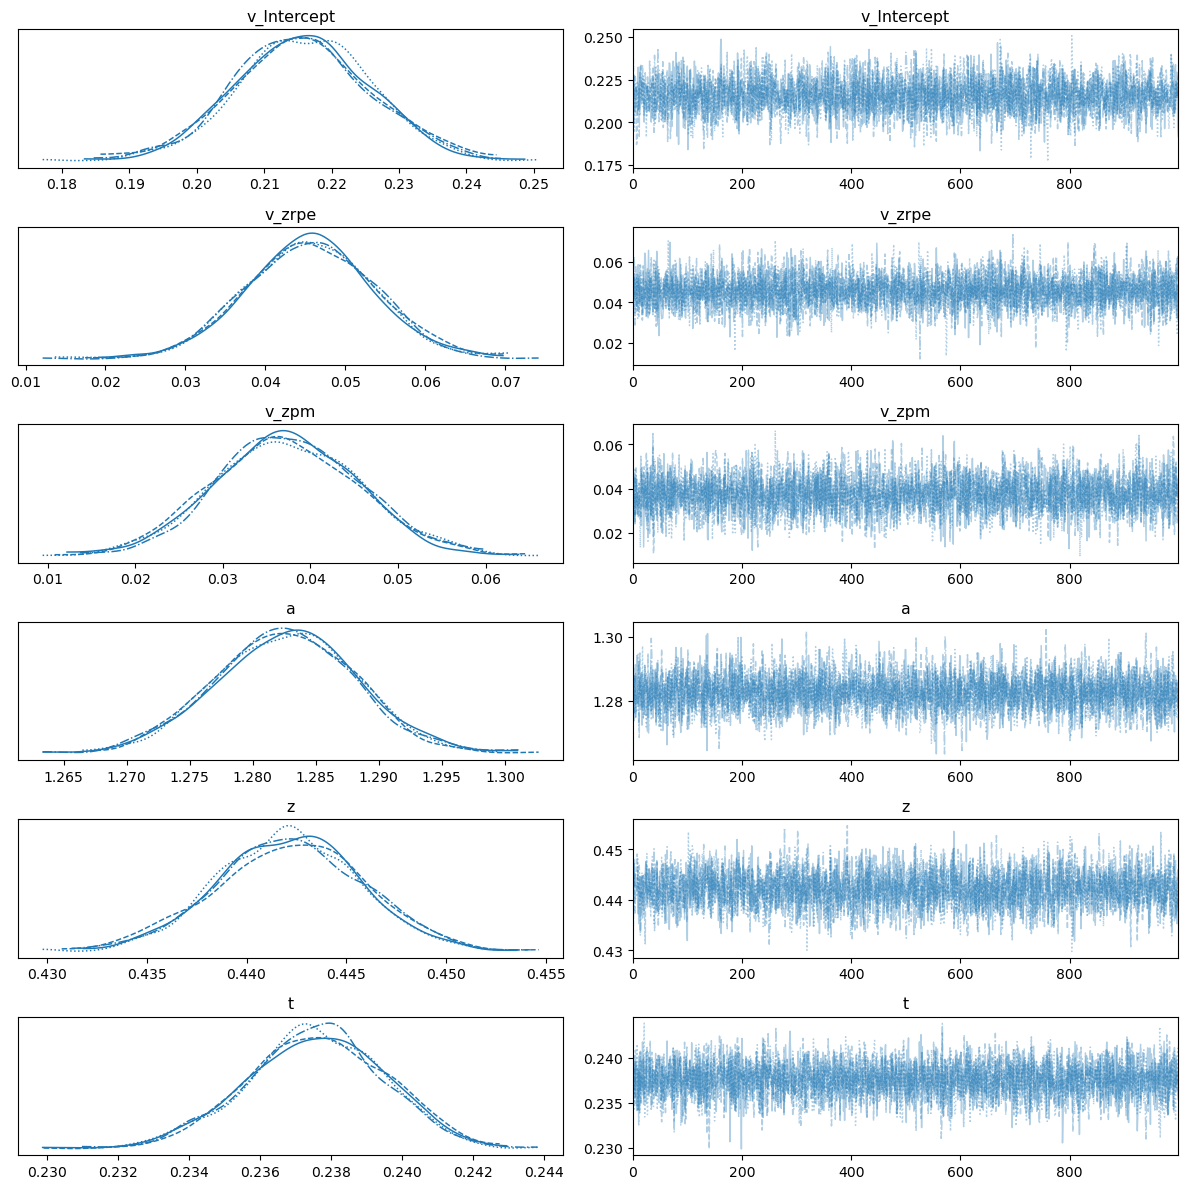

In [30]:
# az.plot_forest(infer_data_model1_hierarchical)
az.plot_trace(model_res['pooled_v'])
plt.tight_layout()

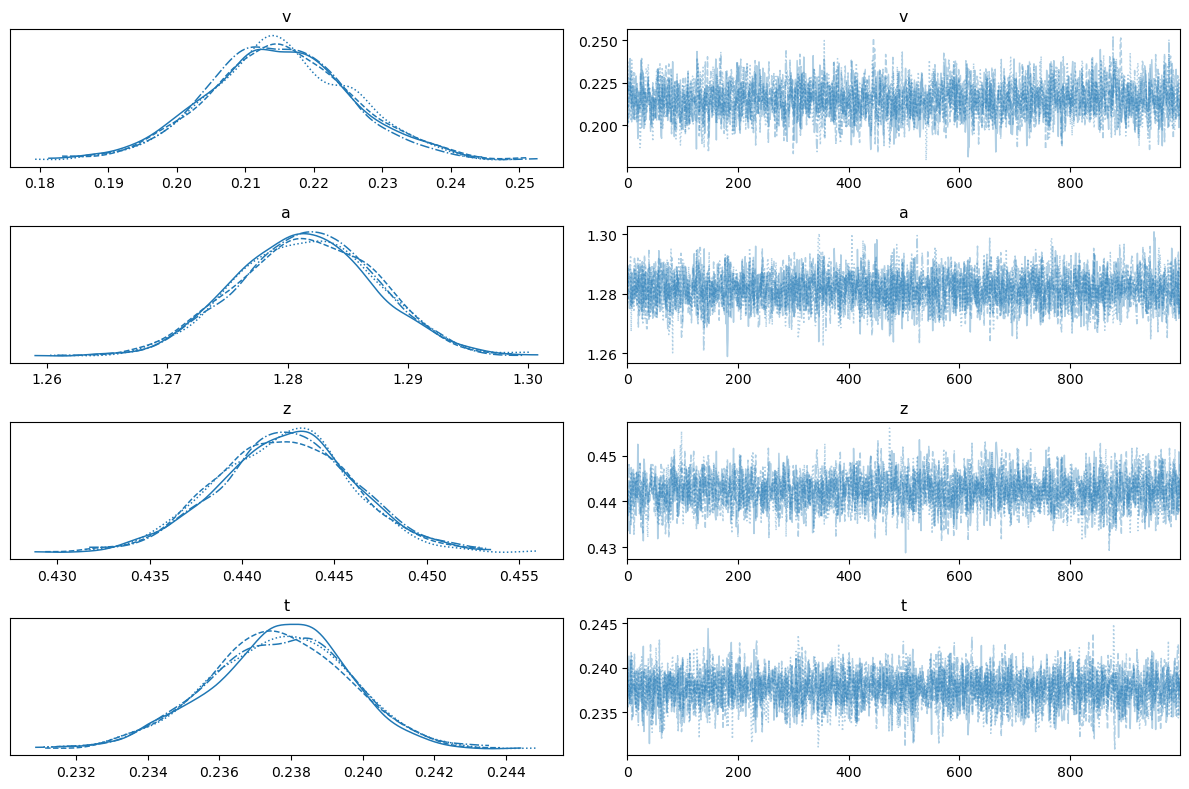

In [21]:
# az.plot_forest(infer_data_model1_hierarchical)
az.plot_trace(model_res['pooled_base'])
plt.tight_layout()

In [135]:
# output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

# all_comps = []

# for subj in tqdm(df.subj_idx.unique()):
#     # specify the subject
#     subj_df = df[df.subj_idx==subj]
    
#     # specify the models 
#     rpe_drift = hssm.HSSM(
#         model="ddm",
#         p_outlier = None,
#         lapse = None, 
#         data=subj_df[['rt', 'response', 'zrpe']] ,
#         include=[
#             {
#                 "name": "v",
#                 "prior": {
#                    "zrpe": {"name": "Normal", "mu": 0, "sigma": 3.0},
#                     },
#                 "formula": "v ~ 1 + zrpe",
#                 "link": "identity",
#             },
#         ],
#     )

#     pm_drift = hssm.HSSM(
#         model="ddm",
#         p_outlier = None,
#         lapse = None, 
#         data=subj_df[['rt', 'response', 'zpm']] ,
#         include=[
#             {
#                 "name": "v",
#                 "prior": {
#                    "zpm": {"name": "Normal", "mu": 0, "sigma": 3.0},
#                     },
#                 "formula": "v ~ 1 + zpm",
#                 "link": "identity",
#             },
#         ],
#     )

#     model_types = {'rpe_drift':rpe_drift,
#                   'pm_drift':pm_drift}    

#     model_res = {f'{x}':[] for x in model_types.keys()}

#     for model_key, model in model_types.items(): 
#         idata = model.sample(
#             chains = 4,
#             cores = 4,
#             draws = 1000,
#             tune = 1000,
#             target_accept=0.95,
#             idata_kwargs=dict(log_likelihood=True))

# #         az.to_netcdf(idata, f"{output_dir}/{subj}_{model_key}_model")

#         model_res[model_key] = idata

#     df_comp_loo = az.compare(model_res, ic='loo')
    
#     all_comps.append(df_comp_loo)

  0%|          | 0/172 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
  1%|          | 1/172 [01:56<5:31:20, 116.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
  1%|          | 2/172 [03:55<5:34:52, 118.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posteri

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
  2%|▏         | 4/172 [08:01<5:39:52, 121.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posteri

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posteri

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and hi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
  5%|▍         | 8/172 [16:22<5:37:56, 123.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posteri

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
  6%|▌         | 10/172 [20:25<5:30:43, 122.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and hi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
  7%|▋         | 12/172 [24:22<5:21:13, 120.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posteri

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
  8%|▊         | 14/172 [28:37<5:23:49, 122.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
  9%|▊         | 15/172 [30:37<5:19:41, 122.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
  9%|▉         | 16/172 [32:36<5:14:59, 121.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
 10%|▉         | 17/172 [34:39<5:13:59, 121.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
 10%|█         | 18/172 [36:34<5:06:56, 119.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
 11%|█         | 19/172 [38:31<5:03:01, 118.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zrpe]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/hpc/users/qasims01/.local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and hi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_zpm]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


 12%|█▏        | 20/172 [42:08<5:20:16, 126.42s/it]


ValueError: Not enough samples to build a trace.

In [5]:
test_model = az.from_netcdf('/sc/arion/projects/guLab/Salman/Prolific/pooled_v_model')

In [9]:
pooled_v = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'zrpe', 'zpm']] ,
    include=[
        {
            "name": "v",           
            "formula": "v ~ 1 + zrpe + zpm",
            "link": "identity",
        },
    ],
)

In [10]:
print(pooled_v)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 10312

Parameters:

v:
    Formula: v ~ 1 + zrpe + zpm
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        v_zrpe ~ Normal(mu: 0.0, sigma: 2.5)
        v_zpm ~ Normal(mu: 0.0, sigma: 2.5)
    Link: identity
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)


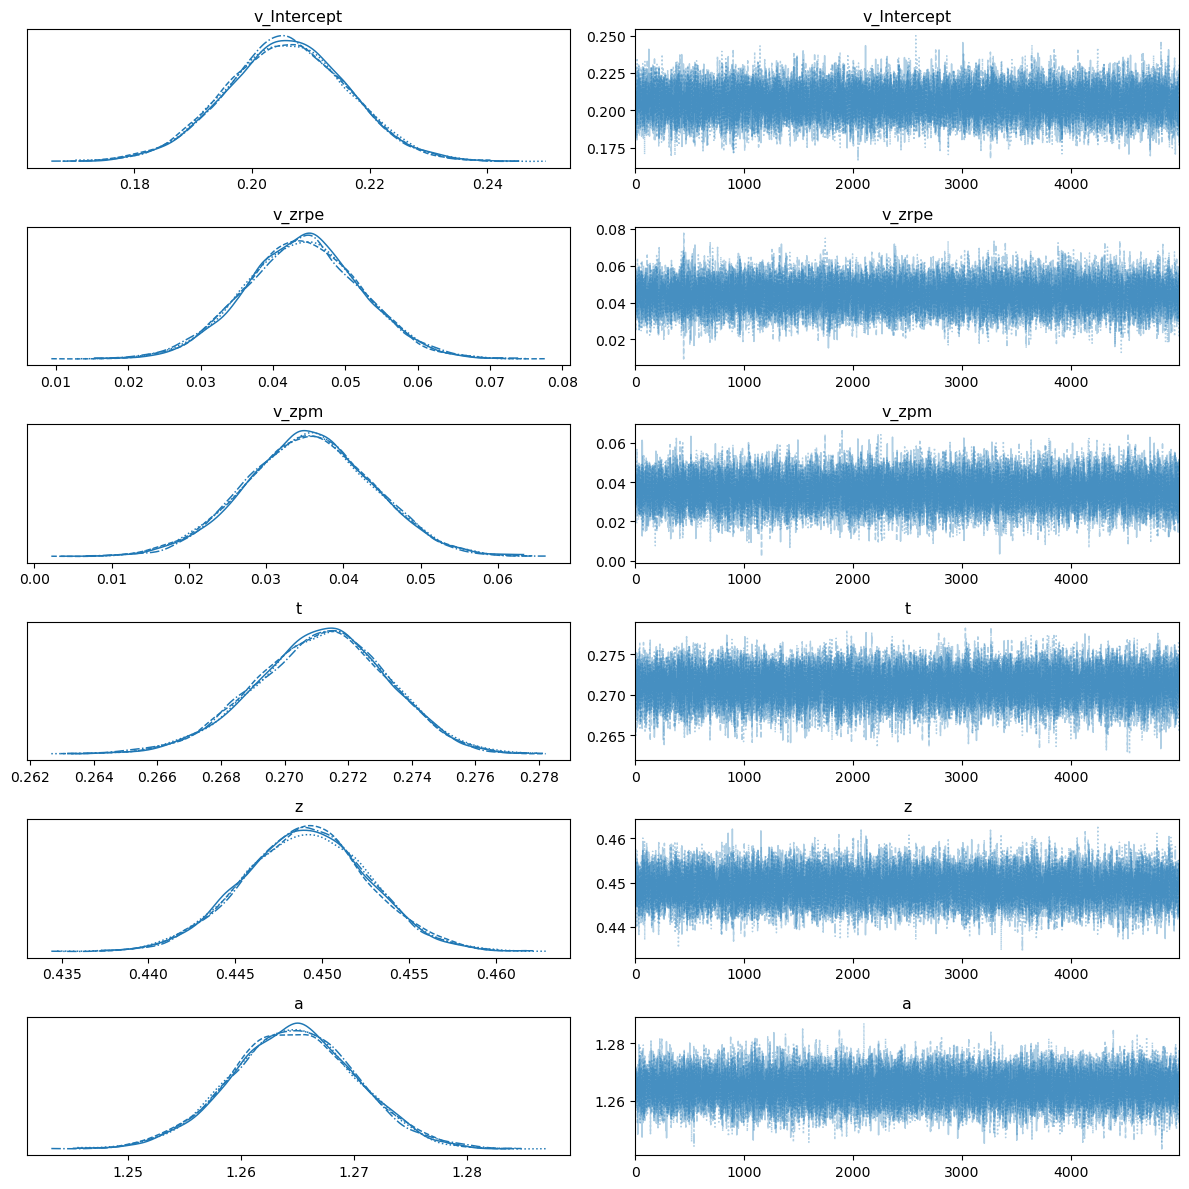

In [7]:
az.plot_trace(test_model)
plt.tight_layout()

## Response to Reviewer 3: more DDMs 

Reviewer 3 wants more DDMs - see if there's a winning version of the model that has nonlinear terms:

In [115]:
# # Here, I am going to define my models:

# hier_v_rpe_pm_randslope_nL1 = hssm.HSSM(
#     model="ddm",
#     p_outlier = None,
#     lapse = None, 
#     data=df[['rt', 'response', 'subj_idx', 'zrpe', 'zpm']] ,
#     include=[
#         {
#             "name": "v",
#             "formula": "v ~ 1 + (1 + I(zrpe**2) + zpm|subj_idx) + I(zrpe**2) + zpm",
#             "link": "identity",
#         },
#     ],
# )

# # hier_v_rpe_pm_randslope_nL2 = hssm.HSSM(
# #     model="ddm",
# #     p_outlier = None,
# #     lapse = None, 
# #     data=df[['rt', 'response', 'subj_idx', 'zrpe', 'zpm']] ,
# #     include=[
# #         {
# #             "name": "v",
# #             "formula": "v ~ 1 + (1 + zrpe + I(zpm**2)|subj_idx) + zrpe + I(zpm**2)",
# #             "link": "identity",
# #         },
# #     ],
# # )


# # hier_v_rpe_pm_randslope_nL3 = hssm.HSSM(
# #     model="ddm",
# #     p_outlier = None,
# #     lapse = None, 
# #     data=df[['rt', 'response', 'subj_idx', 'zrpe', 'zpm']] ,
# #     include=[
# #         {
# #             "name": "v",
# #             "formula": "v ~ 1 + (1 + I(zrpe**2) + I(zpm**2)|subj_idx) + I(zrpe**2) + I(zpm**2)",
# #             "link": "identity",
# #         },
# #     ],
# # )

# hier_v_rpe_pm_randslope_nL4 = hssm.HSSM(
#     model="ddm",
#     p_outlier = None,
#     lapse = None, 
#     data=df[['rt', 'response', 'subj_idx', 'log_rpe', 'zpm']] ,
#     include=[
#         {
#             "name": "v",
#             "formula": "v ~ 1 + (1 + log_rpe + zpm|subj_idx) + log_rpe + zpm",
#             "link": "identity",
#         },
#     ],
# )

# hier_v_rpe_pm_randslope_nL5 = hssm.HSSM(
#     model="ddm",
#     p_outlier = None,
#     lapse = None, 
#     data=df[['rt', 'response', 'subj_idx', 'zrpe', 'log_pm']] ,
#     include=[
#         {
#             "name": "v",
#             "formula": "v ~ 1 + (1 + zrpe + log_pm|subj_idx) + zrpe + log_pm",
#             "link": "identity",
#         },
#     ],
# )


# hier_v_rpe_pm_randslope_nL6 = hssm.HSSM(
#     model="ddm",
#     p_outlier = None,
#     lapse = None, 
#     data=df[['rt', 'response', 'subj_idx', 'log_rpe', 'log_pm']] ,
#     include=[
#         {
#             "name": "v",
#             "formula": "v ~ 1 + (1 + log_rpe + log_pm|subj_idx) + log_rpe + log_pm",
#             "link": "identity",
#         },
#     ],
# )

# hier_v_rpe_pm_randslope = hssm.HSSM(
#     model="ddm",
#     p_outlier = None,
#     lapse = None, 
#     data=df[['rt', 'response', 'subj_idx', 'zrpe', 'zpm']] ,
#     include=[
#         {
#             "name": "v",
#             "formula": "v ~ 1 + (1 + zrpe + zpm|subj_idx) + zrpe + zpm",
#             "link": "identity",
#         },
#     ],
# )

# model_types = {'hier_v_rpe_pm_randslope':hier_v_rpe_pm_randslope,
#                'hier_v_rpe_pm_randslope1':hier_v_rpe_pm_randslope_nL1, 
#                'hier_v_rpe_pm_randslope4':hier_v_rpe_pm_randslope_nL4,
#                'hier_v_rpe_pm_randslope5':hier_v_rpe_pm_randslope_nL5,
#                'hier_v_rpe_pm_randslope6':hier_v_rpe_pm_randslope_nL6}

# #     loglik_kind="approx_differentiable",
# #                'hier_v_rpe_pm_randslope2':hier_v_rpe_pm_randslope_nL2,  
# #               'hier_v_rpe_pm_randslope3':hier_v_rpe_pm_randslope_nL3,

In [117]:
# Here, I am going to define my models:

hier_v_rpe = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + zrpe|subj_idx) + zrpe",
            "link": "identity",
        },
    ],
)


hier_v_rpe_1 = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + I(zrpe**2)|subj_idx) + I(zrpe**2)",
            "link": "identity",
        },
    ],
)


hier_v_rpe_2 = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'log_rpe']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + log_rpe|subj_idx) + log_rpe",
            "link": "identity",
        },
    ],
)


model_types = {'hier_v_rpe':hier_v_rpe,
               'hier_v_rpe_1':hier_v_rpe_1, 
               'hier_v_rpe_2':hier_v_rpe_2}

#     loglik_kind="approx_differentiable",
#                'hier_v_rpe_pm_randslope2':hier_v_rpe_pm_randslope_nL2,  
#               'hier_v_rpe_pm_randslope3':hier_v_rpe_pm_randslope_nL3,

In [118]:
if __name__ == "__main__":
    model_res = {f'{x}':[] for x in model_types.keys()}

    output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

    for model_key, model in model_types.items(): 
        idata = model.sample(
            sampler='nuts_numpyro',
            chains = 4,
            cores = 4,
            draws = 5000,
            tune = 5000,
            idata_kwargs=dict(log_likelihood=True))

        az.to_netcdf(idata, f"{output_dir}/{model_key}_model")

        model_res[model_key] = idata

    df_comp_loo = az.compare(model_res, ic='loo')

Compiling...
Compilation time = 0:00:09.043469
Sampling...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Sampling time = 1:24:00.537512
Transforming variables...
Transformation time = 0:00:00.316338
Computing Log Likelihood...
Log Likelihood time = 0:00:41.190413
Compiling...
Compilation time = 0:00:04.154911
Sampling...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Sampling time = 1:40:30.665794
Transforming variables...
Transformation time = 0:00:00.227143
Computing Log Likelihood...
Log Likelihood time = 0:00:40.757161
Compiling...
Compilation time = 0:00:04.242422
Sampling...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Sampling time = 1:33:34.251729
Transforming variables...
Transformation time = 0:00:00.259439
Computing Log Likelihood...
Log Likelihood time = 0:00:40.645610


In [121]:
df_comp_loo = az.compare(model_res, ic='waic')

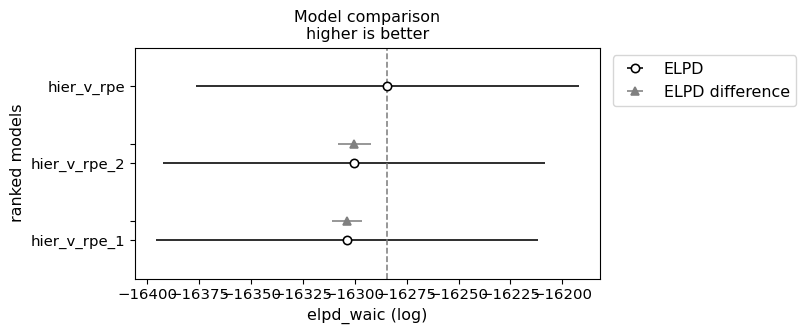

In [122]:
az.plot_compare(df_comp_loo)
plt.savefig(f'{save_dir_plots}/ddm_model_comparison_RPE_only_nonlinear_R3.pdf', dpi=300)


In [120]:
save_dir_plots

'/sc/arion/projects/guLab/Salman/MemoryBanditManuscript/Figures/Exp1'

The original model with no non-linear relationships fits the data best. Now we are going to look at other parameters

In [8]:
# Here, I am going to define my models:

hier_t_rpe_pm_randslope = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe', 'zpm']] ,
    include=[
        {
            "name": "t",
            "formula": "t ~ 1 + (1 + zrpe + zpm|subj_idx) + zrpe + zpm",
            "link": "identity",
        },
    ],
)

hier_v_rpe_pm_randslope = hssm.HSSM(
    model="ddm",
    p_outlier = None,
    lapse = None, 
    data=df[['rt', 'response', 'subj_idx', 'zrpe', 'zpm']] ,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1 + zrpe + zpm|subj_idx) + zrpe + zpm",
            "link": "identity",
        },
    ],
)

model_types = {'hier_t_rpe_pm_randslope':hier_t_rpe_pm_randslope,
               'hier_v_rpe_pm_randslope':hier_v_rpe_pm_randslope}


In [9]:
if __name__ == "__main__":
    model_res = {f'{x}':[] for x in model_types.keys()}

    output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

    for model_key, model in model_types.items(): 
        # Check if the model exists already. If so, load it into the dictionary
        if os.path.isfile(f"{output_dir}/{model_key}_model"):
            idata = az.from_netcdf(f"{output_dir}/{model_key}_model")
        else:
            idata = model.sample(
                sampler='nuts_numpyro',
                chains = 4,
                cores = 4,
                draws = 2000,
                tune = 2000,
                idata_kwargs=dict(log_likelihood=True))

            az.to_netcdf(idata, f"{output_dir}/{model_key}_model")

        model_res[model_key] = idata

    df_comp_loo = az.compare(model_res, ic='loo')

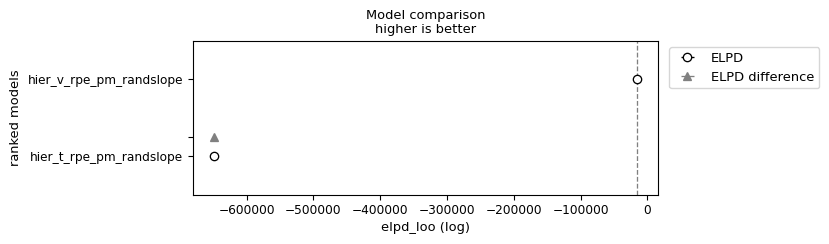

In [10]:
az.plot_compare(df_comp_loo)
plt.savefig(f'{save_dir_plots}/ddm_model_comparison_nonV_R3_RPE_only_vt.pdf', dpi=300)


Does the model coefficient correlate with factor scores? 

In [9]:
output_dir = '/sc/arion/projects/guLab/Salman/Prolific'

idata = az.from_netcdf(f"{output_dir}/hier_v_rpe_model")

In [11]:
param_df = az.summary(idata)

In [19]:
subj_df_mean = pd.read_csv('/sc/arion/projects/guLab/Salman/Prolific/subj_level_df_mean.csv')

In [27]:
subj_df_mean = subj_df_mean[['participant', 'f1_score', 'f2_score', 'f3_score']]

In [43]:
subj_df_mean['v_zrpe'] = param_df[-173:]['mean'].values + param_df.iloc[1]['mean']

<Axes: xlabel='f1_score', ylabel='v_zrpe'>

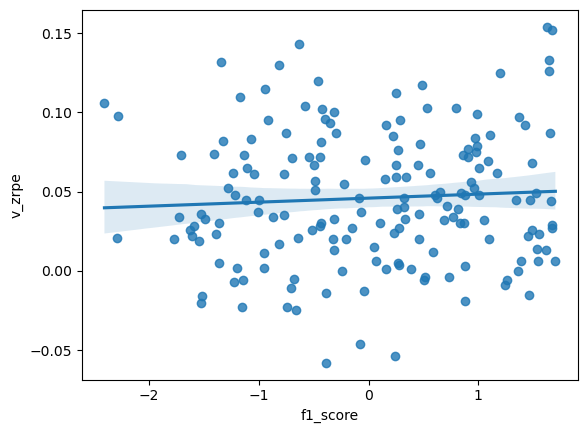

In [45]:
sns.regplot(data=subj_df_mean, x='f1_score', y='v_zrpe')
# sns.regplot(data=subj_df_mean, x='v_zrpe', y='f2_score', scatter=False)
# sns.regplot(data=subj_df_mean, x='v_zrpe', y='f3_score', scatter=False)